In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
import os
import sys
import scipy as sp
from scipy.special import rel_entr
from textwrap import wrap
from matplotlib import animation
from IPython.display import HTML

## Define functions/classes

In [2]:
def js_div(p, q, bins=100):
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    m = 0.5*p_hist + 0.5*q_hist
    kl_1 = sum(rel_entr(p_hist, m))
    kl_2 = sum(rel_entr(q_hist, m))
    return 0.5*(kl_1 + kl_2)

In [3]:
class JointDistribution:
    """
    A class that creates animations comparing two joint distributions.
    """
    def __init__(self, true_distribution, predicted_distributions, axis_lims, iteration_interval):
        """Constructor

        Args:
            true_distribution (ndarray): Bi-dimensional histogram of the true data. 
                                         IMPORTANT: If this array came from the numpy
                                         histogram2d() function, you need to pass the 
                                         transpose to this constructor
            predicted_distributions (list): List of bi-dimensional histograms to be animated. 
            axis_lims (array_like, shape (4,)): axis limits, given as (x_min, x_max, y_min, y_max).
            figsize (array_like, shape(2,)): Size of figure
            dpi (integer): Dots per inch of figure
        """

        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.iteration_interval = iteration_interval
        self.axis_lims = axis_lims
        self.true_distribution = true_distribution


        self.ax1 = self.fig.add_subplot(121)
        self.ax1.set_title("Target Joint Distribution")
        self.ax1.set_xlabel("Parton Jet Pt")
        self.ax1.set_ylabel("True Reco Jet Pt")
        self.ax1.imshow(
            true_distribution,
            origin="lower",
            aspect="auto",
            extent=axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        self.ax2 = self.fig.add_subplot(122)
        self.ax2.set_title("Predicted Joint Distribution")
        self.ax2.set_xlabel("Parton Jet Pt")
        self.ax2.set_ylabel("Predicted Reco Jet Pt")
        self.title = self.ax2.set_title("")
        self.pred_image = self.ax2.imshow(
            [[]],
            origin="lower",
            aspect="auto",
            extent=axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        self.predicted_distributions = predicted_distributions
        self.num_frames = len(predicted_distributions)


    def init(self):
        x = np.linspace(self.axis_lims[0], self.axis_lims[1], 10)
        self.ax2.plot(x, x, c='r', alpha=0.5)
        self.ax1.plot(x, x, c='r', alpha=0.5)
        return self.pred_image

    def update(self, frame):
        self.pred_image.set_data([[]])
        self.pred_image = self.ax2.imshow(
            self.predicted_distributions[frame],
            origin="lower",
            aspect="auto",
            extent=self.axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        #self.pred_image.set_data(self.predicted_distributions[frame])
        self.title.set_text("Predicted Joint Distribution Iteration: {}".format(frame*self.iteration_interval))
        return self.pred_image, self.title

    def make_animation(self):
        anim = animation.FuncAnimation(
            self.fig,
            self.update,
            init_func=self.init,
            frames=np.arange(self.num_frames),
            interval=500,
        )
        return anim

In [4]:
class SingleDistribution:
    def __init__(self, true_distribution, predicted_distributions, axis_limits, iteration_interval):
        self.fig = plt.figure(figsize=(10, 5), dpi=200)
        self.iteration_interval = iteration_interval
        self.axis_limits = axis_limits
        self.true_distribution = true_distribution
        self.predicted_distributions = predicted_distributions


        self.ax = self.fig.add_subplot(111)
        self.ax.set_title("True and Predicted Pt Distributions")
        self.ax.set_xlabel("Pt")
        self.ax.set_ylabel("Count")
        self.bins = np.linspace(axis_limits[0], axis_limits[1], 100)
        self.ax.hist(true_distribution, label="True Reco Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.hist([], label="Predicted Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.legend()
        self.num_frames = len(predicted_distributions)
        
        
    def init(self):
        pass
        
    def update(self, frame):
        self.ax.cla()
        self.ax.hist(self.true_distribution, label="True Reco Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.hist(self.predicted_distributions[frame], label="Predicted Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.set_title("True and Predicted Pt Distributions Iteration: {}".format(frame*self.iteration_interval))
        self.ax.legend()
        self.ax.set_xlim(self.axis_limits[0], self.axis_limits[1])
        self.ax.set_ylim(self.axis_limits[2], self.axis_limits[3])
            
    def make_animation(self):
        anim = animation.FuncAnimation(
            self.fig,
            self.update,
            init_func=self.init,
            frames=np.arange(self.num_frames),
            interval=500,
        )
        return anim
            

In [5]:
def load_jet_data_log_scaling(data_path):
    """Load and normalize the jet data

    Scale Pt and E by taking the log
    Args:
        data_path (path-like): path to txt file with jet 4-momenta

    Returns:
        tuple: tuple of ndarrays (parton_data, reco_data)
    """
    data = np.loadtxt(data_path, skiprows=2, dtype=np.float32)
    partonMean = np.mean(data[:, 1:3], axis=0)
    partonStd = np.std(data[:, 1:3], axis=0)

    pfMean = np.mean(data[:, 5:7], axis=0)
    pfStd = np.std(data[:, 5:7], axis=0)

    np.log10(data[:, 0], out=data[:, 0])
    np.log10(data[:, 3], out=data[:, 3])
    np.log10(data[:, 4], out=data[:, 4])
    np.log10(data[:, 7], out=data[:, 7])
    data[:, 1:3] = (data[:, 1:3] - partonMean) / partonStd
    data[:, 5:7] = (data[:, 5:7] - pfMean) / pfStd

    np.random.shuffle(data)
    parton_data = data[:, :4]
    reco_data = data[:, 4:]
    return (parton_data, reco_data)

In [6]:
def load_jet_data_log_scaling_new(data_path):
    """Load and normalize the jet data

    Scale Pt and E by taking the log
    Args:
        data_path (path-like): path to txt file with jet 4-momenta

    Returns:
        tuple: tuple of ndarrays (parton_data, reco_data)
    """
    data = np.loadtxt(data_path, skiprows=2, dtype=np.float32)
    np.log10(data[:, 0], out=data[:, 0])
    np.log10(data[:, 3], out=data[:, 3])
    np.log10(data[:, 4], out=data[:, 4])
    np.log10(data[:, 7], out=data[:, 7])
    
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    
    data = (data - mean) / std

    np.random.shuffle(data)
    parton_data = data[:, :4]
    reco_data = data[:, 4:]
    return (parton_data, reco_data)

In [7]:
def psquared(pt, eta):
    a = 2*np.arctan(np.exp(-eta))
    return (pt / np.sin(a))**2

In [8]:
def momentum(pt, eta):
    a = 2*np.arctan(np.exp(-eta))
    return (pt / np.sin(a))

## Set Paths

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [10]:
#sys.path.append('../models/cWGAN/Run_2021-03-21_0/')
#sys.path.append('../models/cWGAN/Run_2021-04-11_1/')
sys.path.append('../models/cWGAN/Run_2021-07-25_0/')
import cWGAN

In [12]:
save_dir = '../models/cWGAN/Run_2021-07-25_0/'
assert(os.path.isdir(save_dir))

## Plot Loss Curve

In [12]:
gen_losses = []
with open(save_dir+'generator_losses.txt', 'r') as f:
    for _ in range(2000000):
        line = f.readline()
        begin = int(line.find(')'))
        start = int(line.find('(', begin))
        end = int(line.find(',', begin+2))
        if start > 0:
            gen_losses.append(float(line[start+1:end]))

In [13]:
critic_losses = []
with open(save_dir+'critic_losses.txt', 'r') as f:
    for _ in range(10000000):
        line = f.readline()
        start = int(line.find('('))
        end = int(line.find(','))
        if start > 0:
            critic_losses.append(float(line[start+1:end]))

In [14]:
filtered_gen_losses1 = sp.ndimage.median_filter(gen_losses, size=5000)
#filtered_critic_losses = sp.ndimage.median_filter(critic_losses, size=1000)

In [15]:
print(len(filtered_gen_losses))
#print(len(filtered_critic_losses))
iterations = np.arange(len(filtered_gen_losses))
iterations*=5

NameError: name 'filtered_gen_losses' is not defined

No handles with labels found to put in legend.


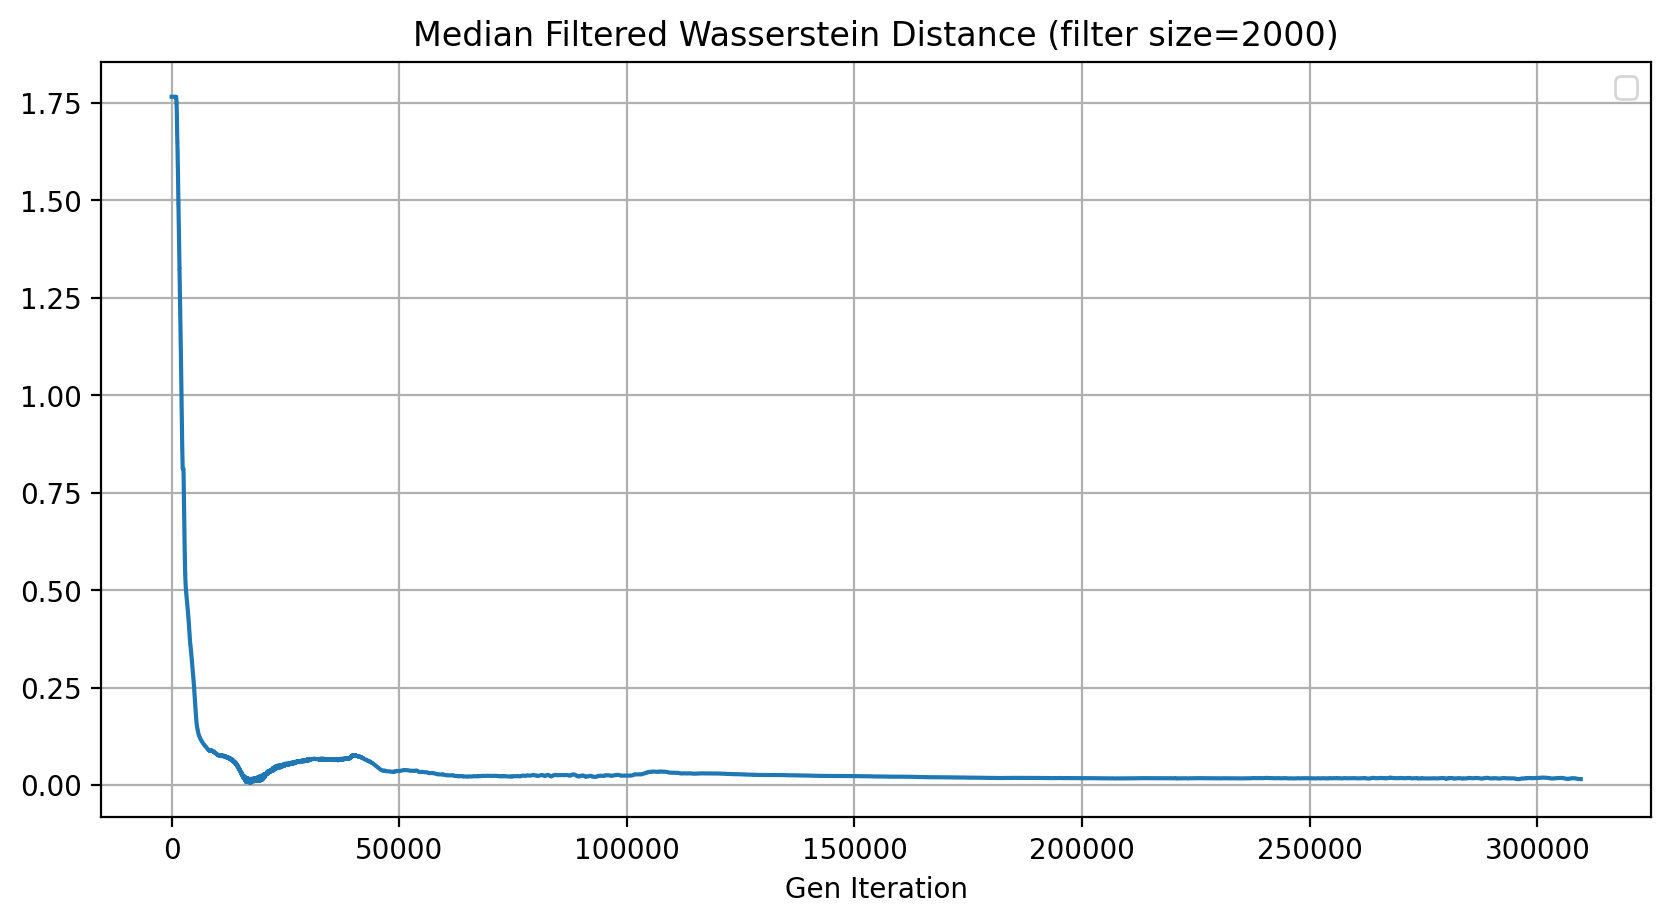

In [16]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.add_subplot(111)
ax.plot(filtered_gen_losses1)
ax.set_xlabel("Gen Iteration")
ax.set_title("Median Filtered Wasserstein Distance (filter size=2000)")
ax.grid()
ax.legend()
plt.show()
#plt.savefig(save_dir + "/LossCurve.png")

## Load data and construct model object

In [13]:
data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCutFixRapMassEventNumberJetTagged.txt", skiprows=2)
#data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCutFixRap.txt", skiprows=2)
#data = np.loadtxt("../data/processed/newPartonMatchedJets.txt", skiprows=2)
print(len(data))

1585139


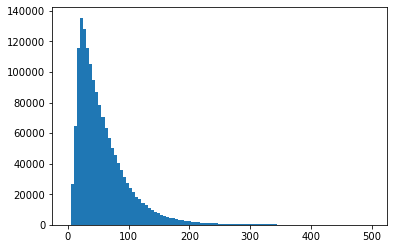

In [14]:
bins = np.linspace(0, 500, 100)
#bins = np.linspace(-5, 5, 100)
plt.hist(data[:, 4], bins=bins)
#plt.hist(data1[:, 4], bins=bins, alpha=0.4)
plt.show()

In [15]:
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)

partonPtMin = np.min(data[:, 0], axis=0)
partonEMin = np.min(data[:, 3], axis=0)
pfMean = np.mean(data[:, 5:7], axis=0)
pfStd = np.std(data[:, 5:7], axis=0)
pfPtMin = np.min(data[:, 4], axis=0)
pfEMin = np.min(data[:, 7], axis=0)

normalized_data = np.zeros((len(data), 4))
reco_data = np.zeros((len(data), 4))


# for inverse scaling
"""
normalized_data[:, 0] = (1/data[:, 0]) * partonPtMin
normalized_data[:, 3] = (1/data[:, 3]) * partonEMin
"""

# for log scaling
np.log10(data[:, 0], out=normalized_data[:, 0])
np.log10(data[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 4], out=reco_data[:, 0])
np.log10(data[:, 7], out=reco_data[:, 3])

normalized_data[:, 1:3] = data[:, 1:3]
reco_data[:, 1:3] = data[:, 5:7]

normalized_mean = np.mean(normalized_data, axis=0)
normalized_std = np.std(normalized_data, axis=0)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)

normalized_data = (normalized_data - normalized_mean) / normalized_std

In [16]:
normalized_p = normalized_data[:, 0]*np.cosh(normalized_data[:, 1])
normalized_mass = normalized_data[:, 3]**2 - normalized_p**2

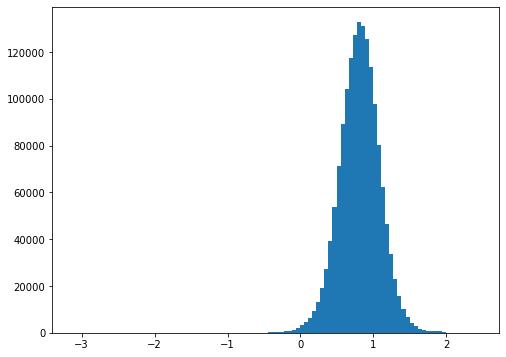

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
bins = np.linspace(-20, 10, 100)
#ax.hist(normalized_mass, bins=bins)
ax.hist(reco_data[:, 3], bins=100)
#ax.hist(np.log(data[:, 0]*np.cosh(data[:, 1])), bins=100)
#ax.hist(np.log(data[:, 0]), bins=100)
plt.show()

In [18]:
cwgan = cWGAN.cWGAN(10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

## Load Weights and Make Predictions

In [29]:
#cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_560000')
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_60000')
#cwgan.critic.load_weights(save_dir + '/training_checkpoints/critic_0')

In [30]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 1min 56s, sys: 7.14 s, total: 2min 3s
Wall time: 4.32 s


In [31]:
predict = predict * reco_std + reco_mean
predict[:, 0] = 10**predict[:, 0]
#reco_data[:, 0] = np.power(reco_data[:, 0], 10)
predict[:, 3] = 10**predict[:, 3]

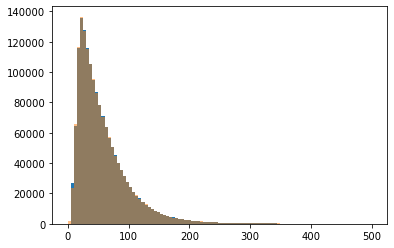

In [32]:
bins = np.linspace(0, 500, 100)
#bins = np.linspace(-5, 5, 100)
#bins = np.linspace(0, 100, 100)
plt.hist(data[:, 4], bins=bins)
plt.hist(predict[:, 0], bins=bins, alpha=0.5)
#plt.xlim(-100, 1000)
plt.show()

## Analyze Pt Predictions

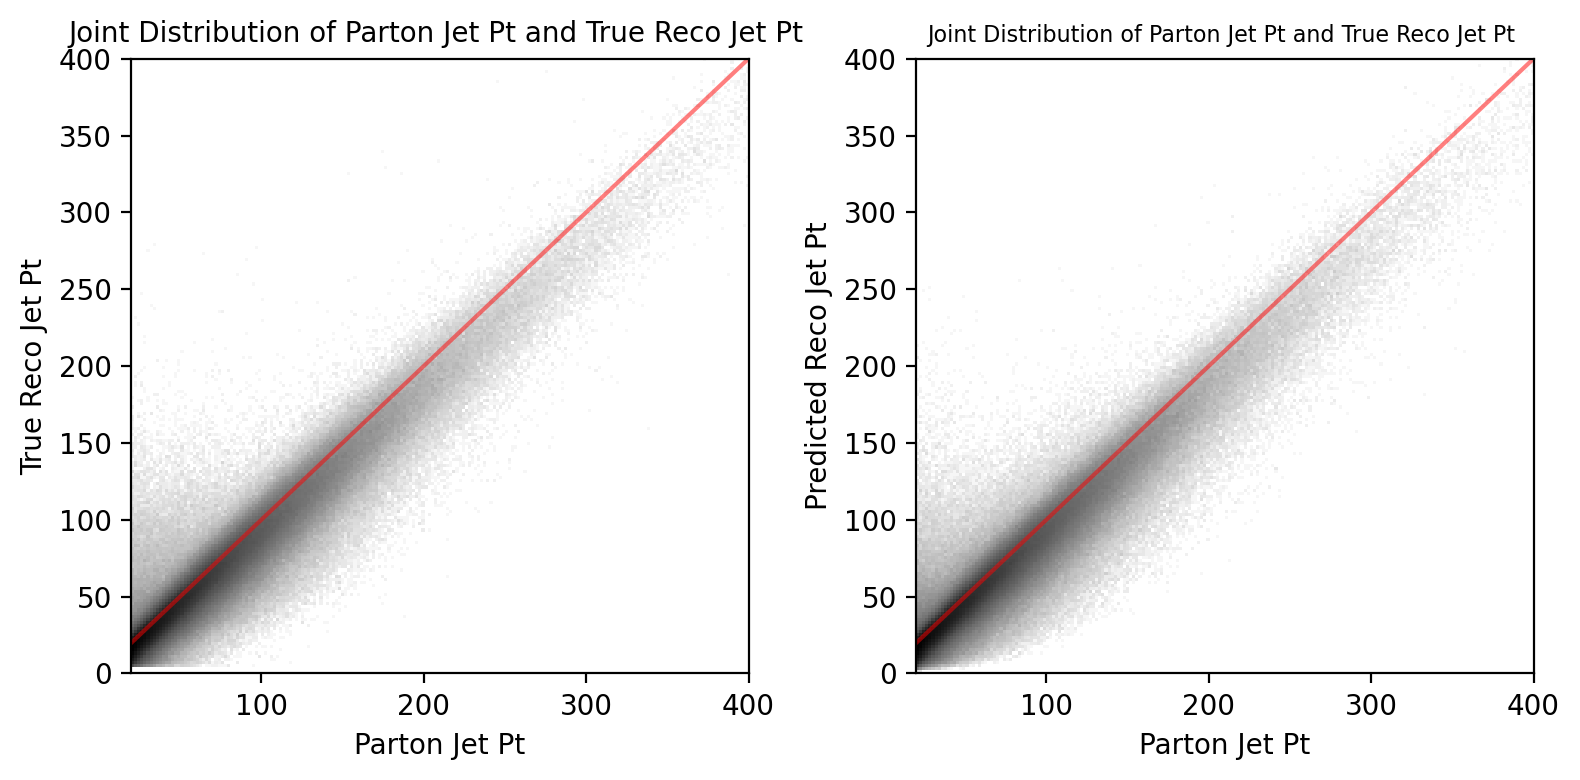

In [33]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 400
y_low = 0
y_hi = 400
num_bins=200


h2, xbins, ybins = np.histogram2d(data[:, 0], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel("Parton Jet Pt")
ax1.set_ylabel("True Reco Jet Pt")
ax1.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=10)
#ax1.set_xlim(0, 200)
#ax1.set_ylim(0, 200)


z2, xbins, ybins = np.histogram2d(data[:, 0], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel("Parton Jet Pt")
ax2.set_ylabel("Predicted Reco Jet Pt")
ax2.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=8)
#ax2.set_xlim(0, 200)
#ax2.set_ylim(-50, 200)

# plot y=x line to make comparison easier
x = np.linspace(x_low, x_hi, 10)
ax1.plot(x, x, c='r', alpha=0.5)
ax2.plot(x, x, c='r', alpha=0.5)

plt.tight_layout()
plt.show()
#plt.savefig(save_dir + '/JointPtDistributions.png')

In [24]:
joint_distributions = []
for i in range(150):
    iteration = str(i*5000)
    if i % 10 == 0: 
        print(iteration)
    cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_' + iteration)
    predict = np.array(cwgan.make_generator_predictions(normalized_data))
    predict = predict * reco_std + reco_mean    
    predict[:, 0] = 10**predict[:, 0]
    
    #predict[:, 1:3] = predict[:, 1:3] * pfStd + pfMean
    #predict[:, 3] = pfEMin/predict[:, 3] 
    z2, xbins, ybins = np.histogram2d(data[:, 0], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
    joint_distributions.append(z2.T)

0
50000


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../models/cWGAN/Run_2021-07-25_0//training_checkpoints/gen_65000

1581928.0
1582080.0


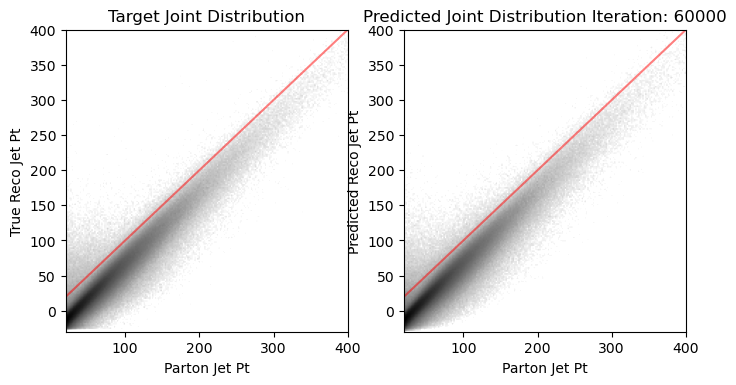

In [25]:
print(np.sum(h2))
print(np.sum(z2))
jd = JointDistribution(h2.T, joint_distributions, (20, 400, -30, 400), 5000)
anim = jd.make_animation()
HTML(anim.to_jshtml())


In [ ]:
writer = animation.PillowWriter(fps=2) 
anim.save(save_dir + 'joint_pt_dist.gif', writer=writer)

In [26]:
single_distributions = []
for i in range(145):
    iteration = str(i*5000)
    if i % 10 == 0:    
        print(iteration)
    cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_' + iteration)
    predict = np.array(cwgan.make_generator_predictions(normalized_data))
    predict = predict * reco_std + reco_mean    
    #predict[:, 0] = 10**predict[:, 0]
    single_distributions.append(predict[:, 1])

0
50000


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../models/cWGAN/Run_2021-07-25_0//training_checkpoints/gen_65000

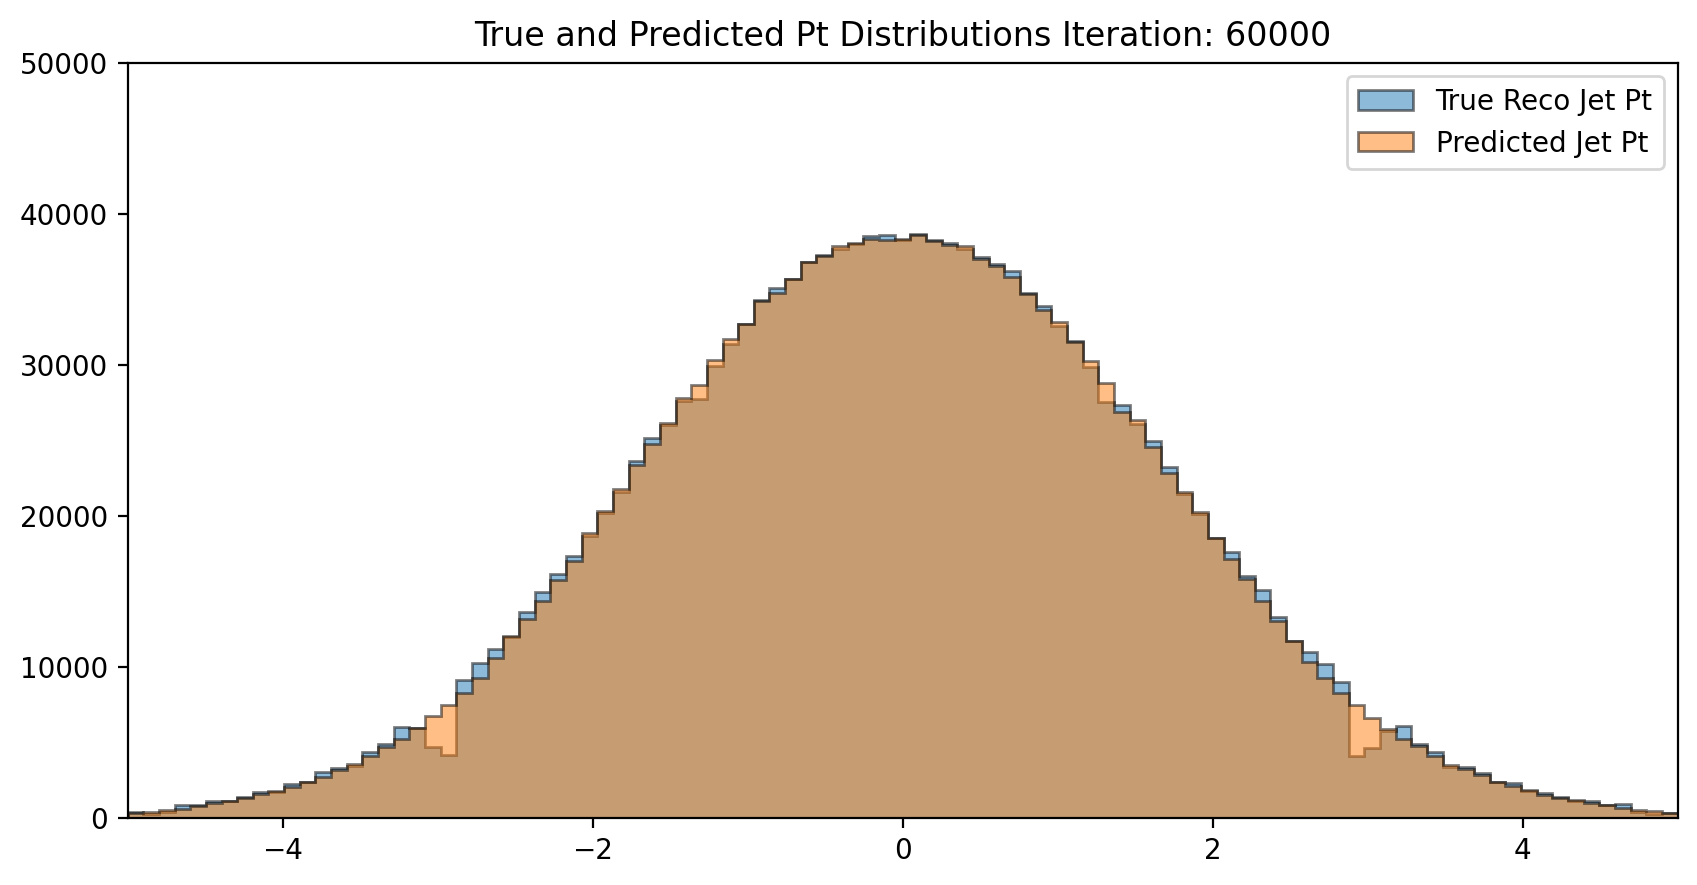

In [27]:
sd = SingleDistribution(data[:, 5], single_distributions, (-5, 5, 0, 50000), 5000)
anim = sd.make_animation()
HTML(anim.to_jshtml())

In [42]:
writer = animation.PillowWriter(fps=2) 
anim.save(save_dir + 'pt_single_dist.gif', writer=writer)

### Look more closely at specific iterations

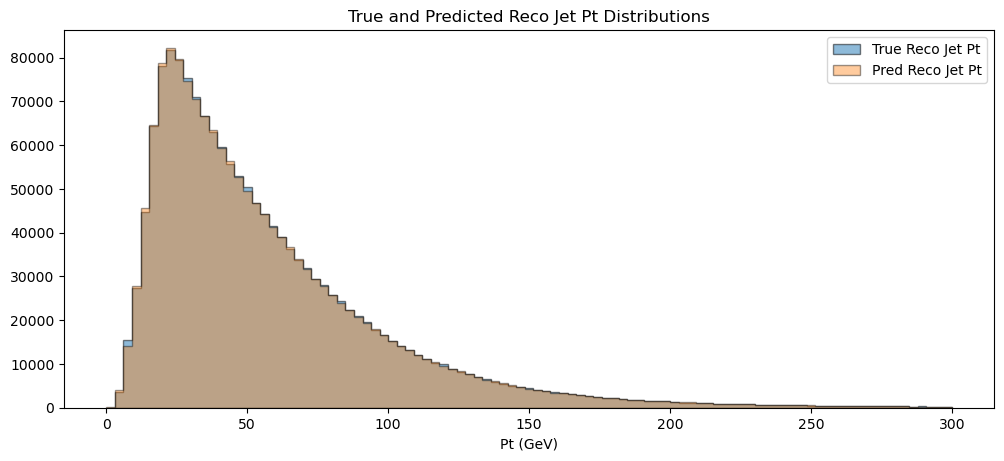

In [34]:
fig = plt.figure(figsize=(12,5), dpi=100)
bins = np.linspace(0, 300, 100)
ax = fig.add_subplot(111)
ax.hist(data[:, 4], label="True Reco Jet Pt", bins=bins, alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(predict[:, 0], label="Pred Reco Jet Pt", bins=bins, alpha=0.4, ec="k", histtype='stepfilled')
ax.set_title("True and Predicted Reco Jet Pt Distributions")
ax.set_xlabel("Pt (GeV)")
ax.legend()
plt.show()

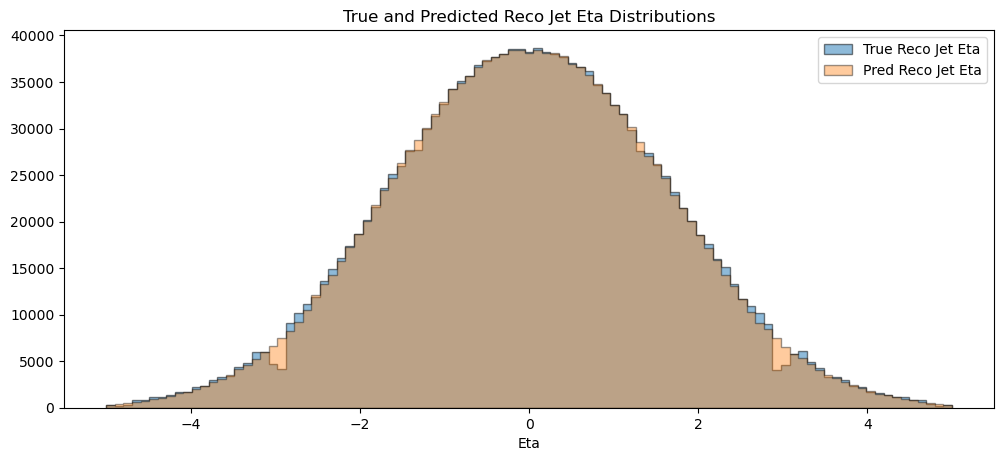

In [35]:
fig = plt.figure(figsize=(12,5), dpi=100)
bins = np.linspace(-5, 5, 100)
ax = fig.add_subplot(111)
ax.hist(data[:, 5], label="True Reco Jet Eta", bins=bins, alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(predict[:, 1], label="Pred Reco Jet Eta", bins=bins, alpha=0.4, ec="k", histtype='stepfilled')
ax.set_title("True and Predicted Reco Jet Eta Distributions")
ax.set_xlabel("Eta")
ax.legend()
plt.show()

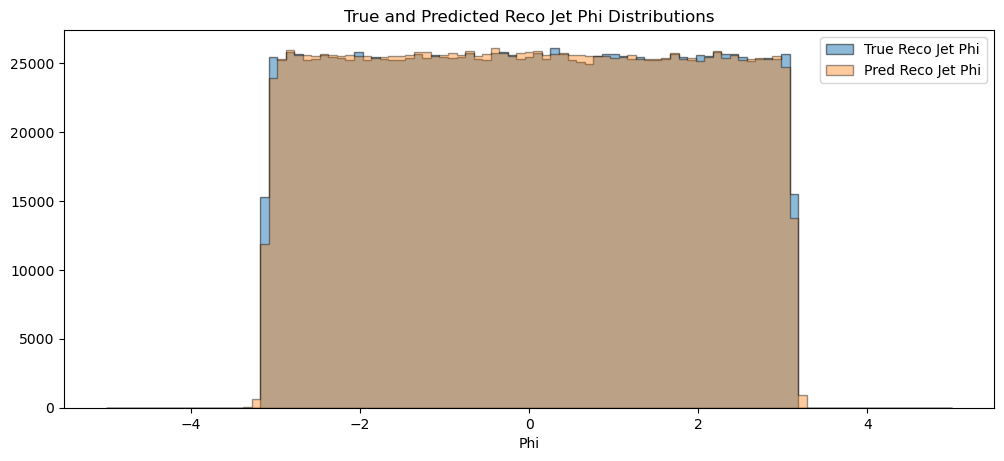

In [36]:
fig = plt.figure(figsize=(12,5), dpi=100)
bins = np.linspace(-5, 5, 100)
ax = fig.add_subplot(111)
ax.hist(data[:, 6], label="True Reco Jet Phi", bins=bins, alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(predict[:, 2], label="Pred Reco Jet Phi", bins=bins, alpha=0.4, ec="k", histtype='stepfilled')
ax.set_title("True and Predicted Reco Jet Phi Distributions")
ax.set_xlabel("Phi")
ax.legend()
plt.show()

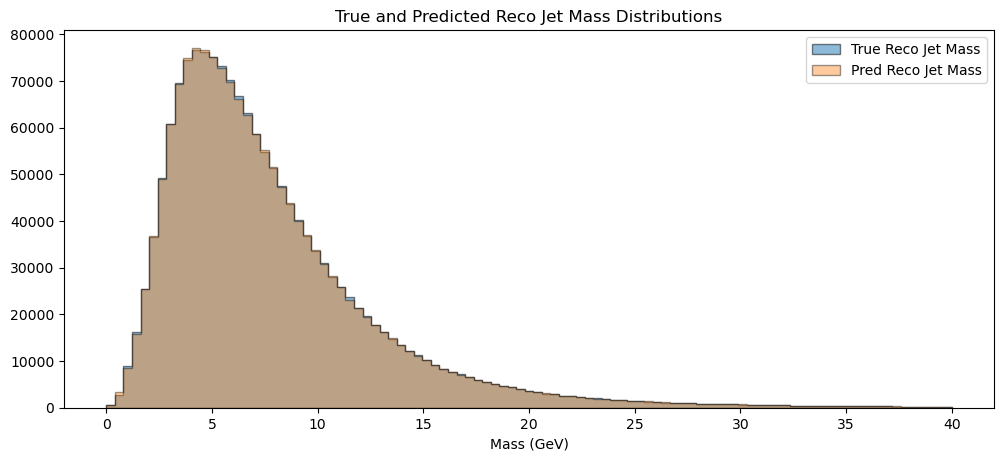

In [37]:
fig = plt.figure(figsize=(12,5), dpi=100)
bins = np.linspace(0, 40, 100)
ax = fig.add_subplot(111)
ax.hist(data[:, 7], label="True Reco Jet Mass", bins=bins, alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(predict[:, 3], label="Pred Reco Jet Mass", bins=bins, alpha=0.4, ec="k", histtype='stepfilled')
ax.set_title("True and Predicted Reco Jet Mass Distributions")
ax.set_xlabel("Mass (GeV)")
ax.legend()
plt.show()

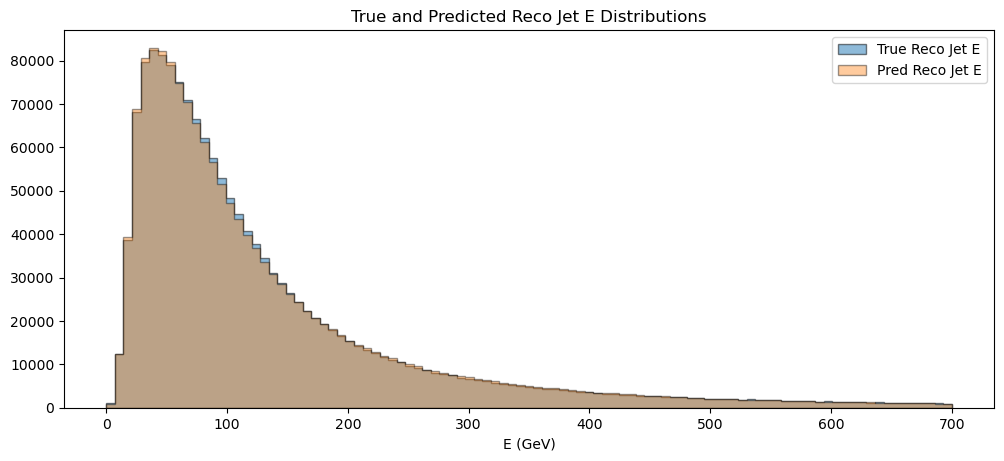

In [38]:
fig = plt.figure(figsize=(12,5), dpi=100)
bins = np.linspace(0, 700, 100)
ax = fig.add_subplot(111)
ax.hist(np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), label="True Reco Jet E", bins=bins, alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), label="Pred Reco Jet E", bins=bins, alpha=0.4, ec="k", histtype='stepfilled')
ax.set_title("True and Predicted Reco Jet E Distributions")
ax.set_xlabel("E (GeV)")
ax.legend()
plt.show()

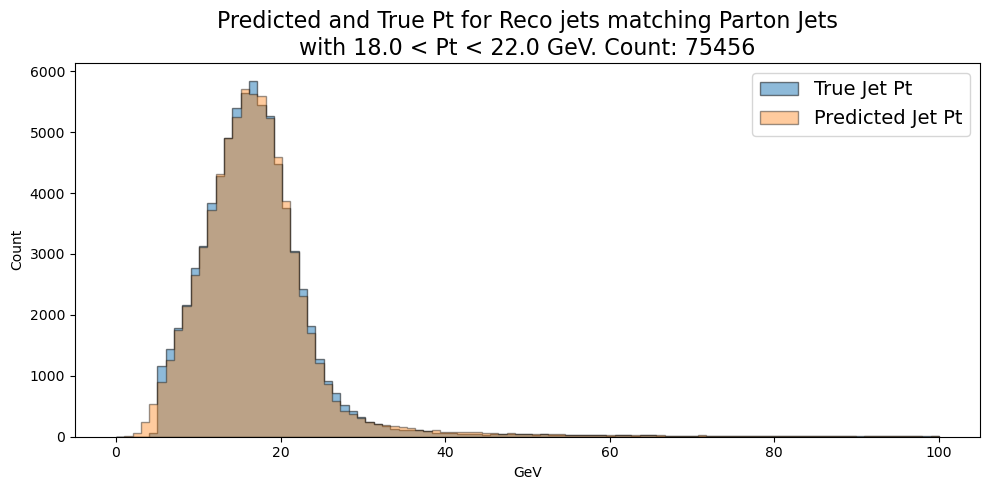

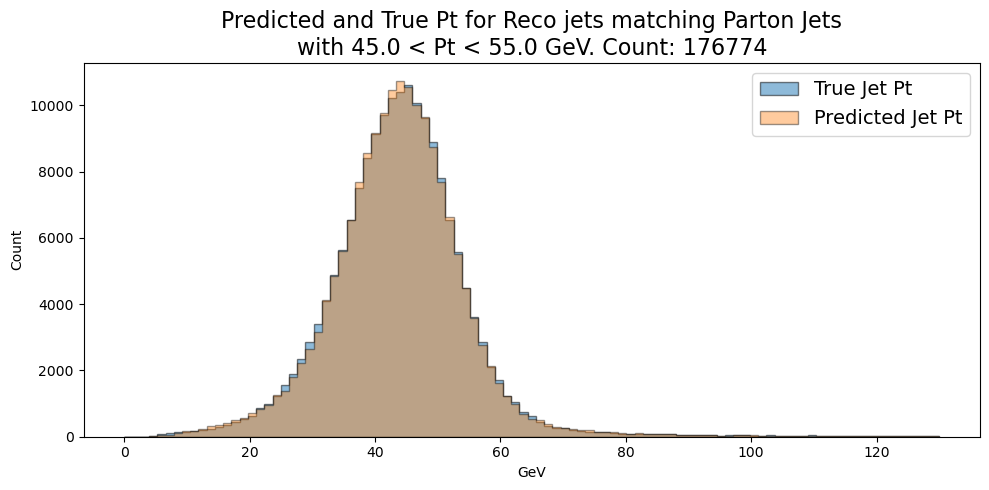

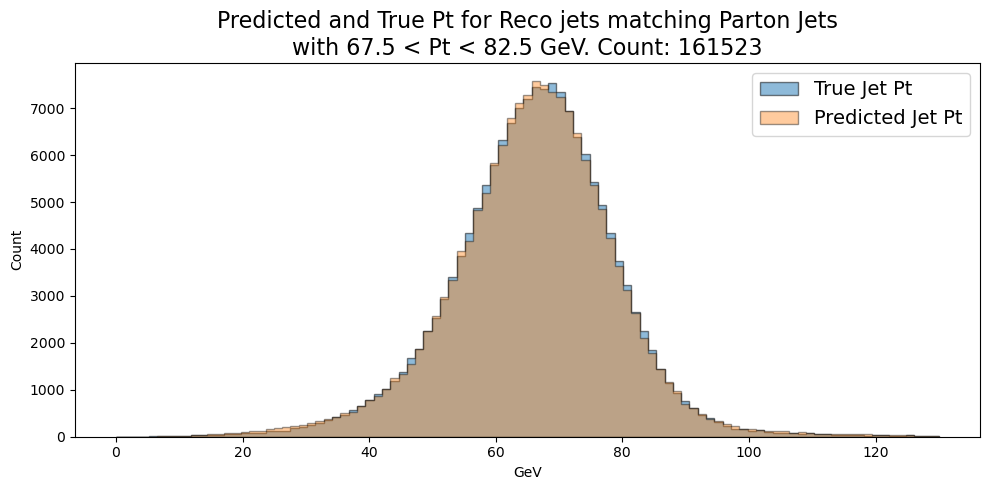

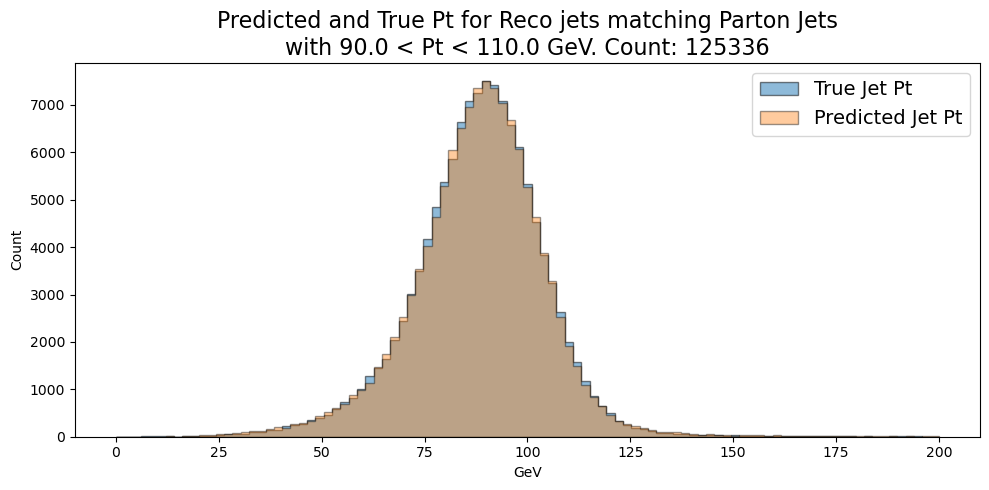

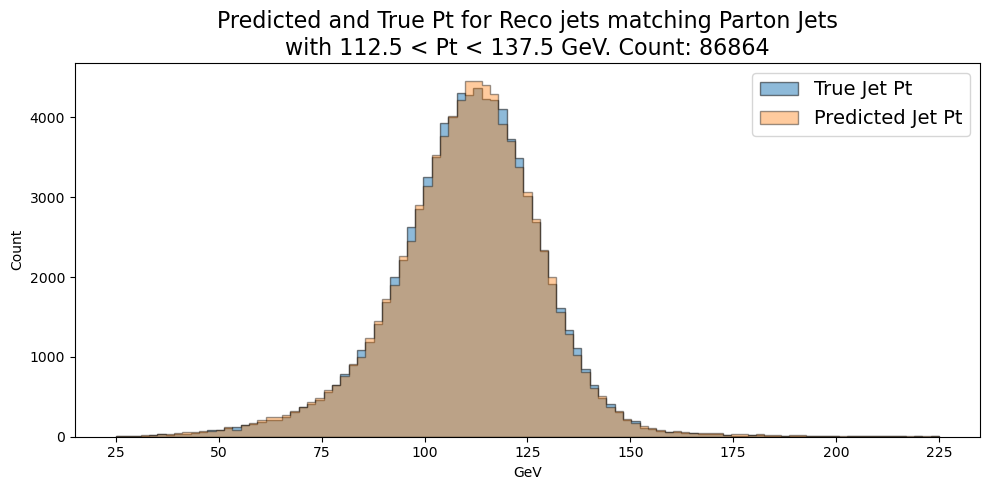

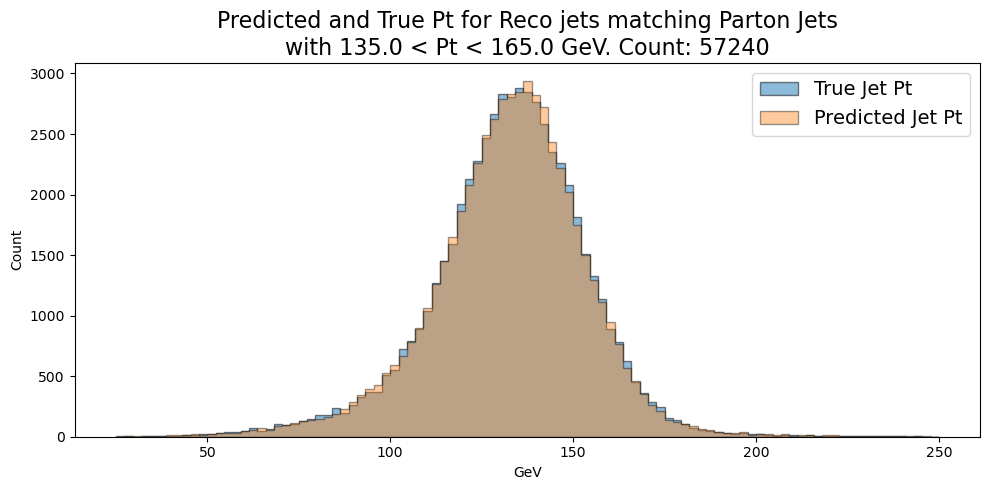

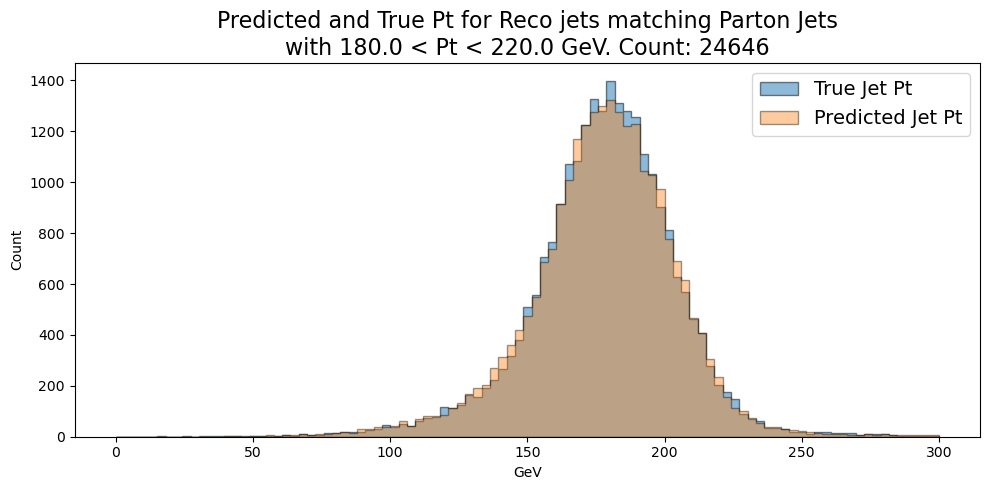

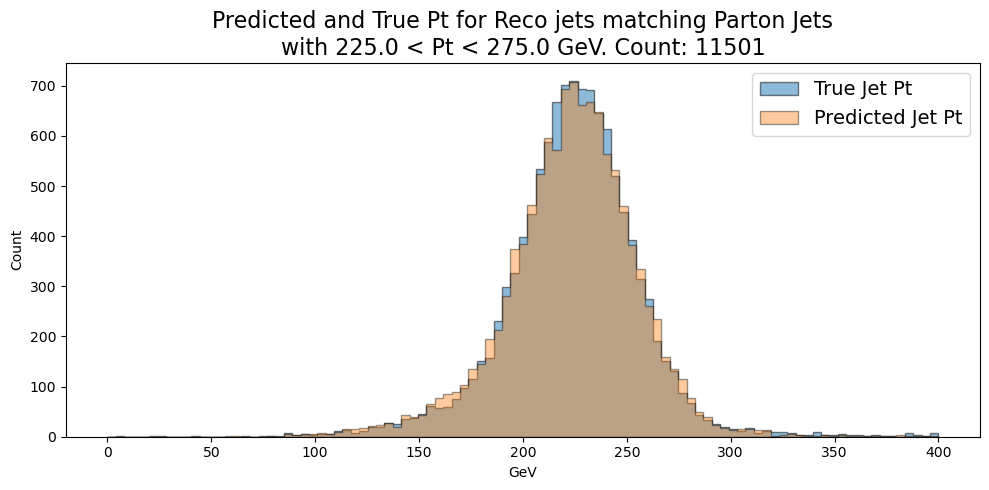

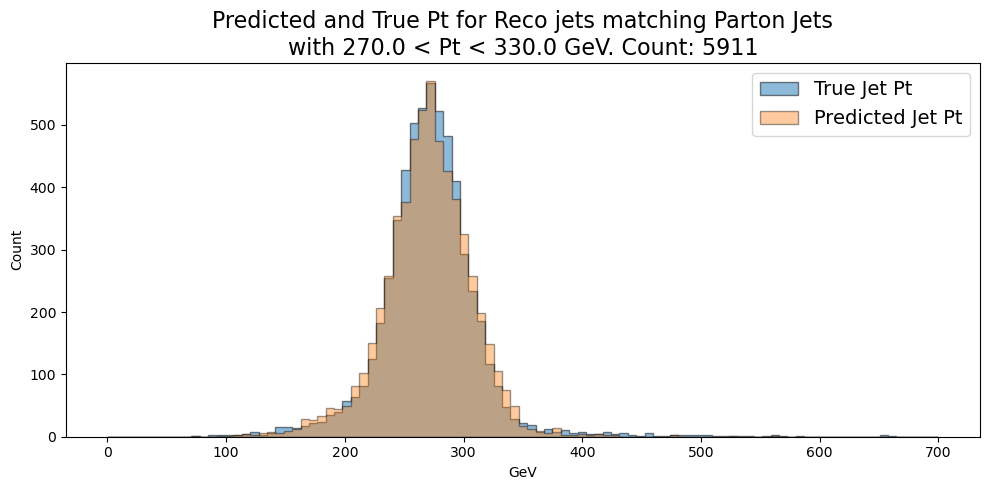

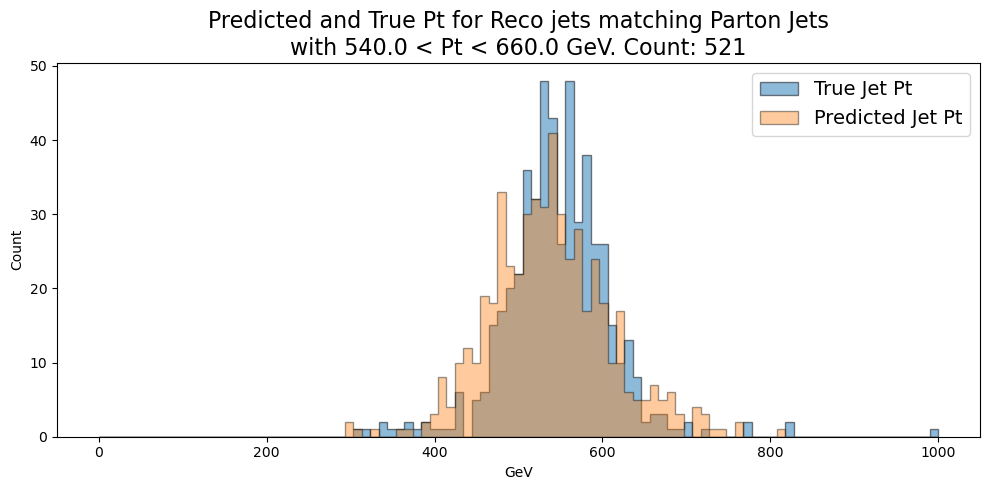

In [39]:
range_highs = [100, 130, 130, 200, 225, 250, 300, 400, 700, 1000]
range_lows = [0, 0, 0, 0, 25, 25, 0, 0, 0, 0]
j = 0
for center in [20, 50, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(recoPt)), width=60)), fontsize=16)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig(save_dir+"/PtDistLog{}.png".format(j), facecolor="white", transparent="True")
    j+=1


In [16]:
for i in range(1):
    print(data[i, 7]**2 - psquared(data[i, 4], data[i, 5]))

54.30548834532965


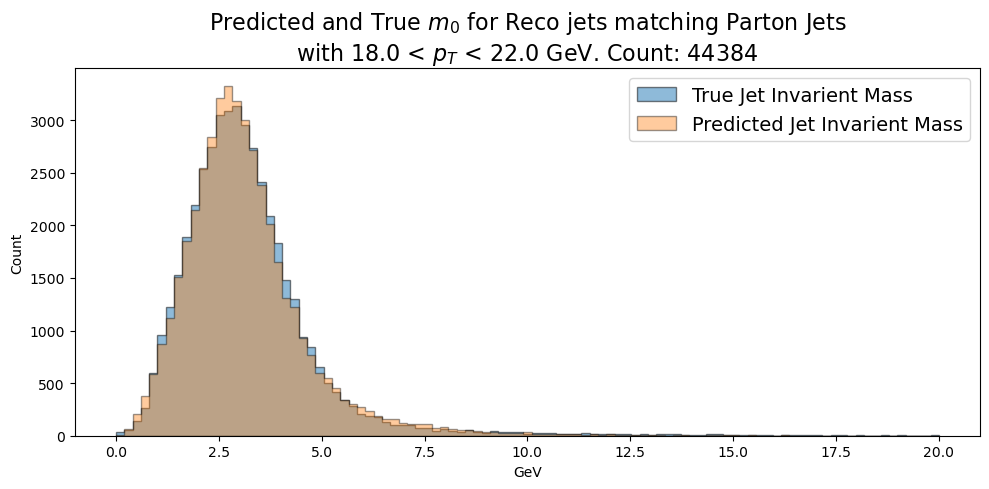

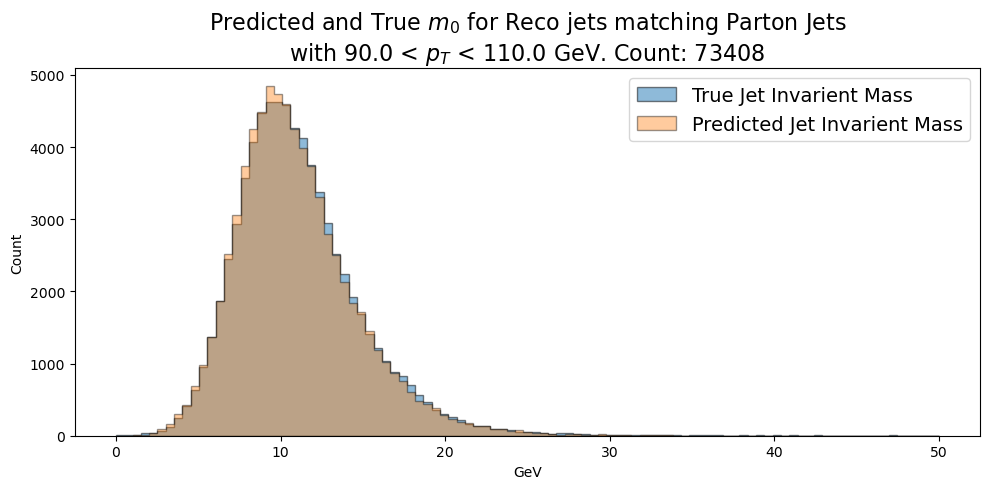

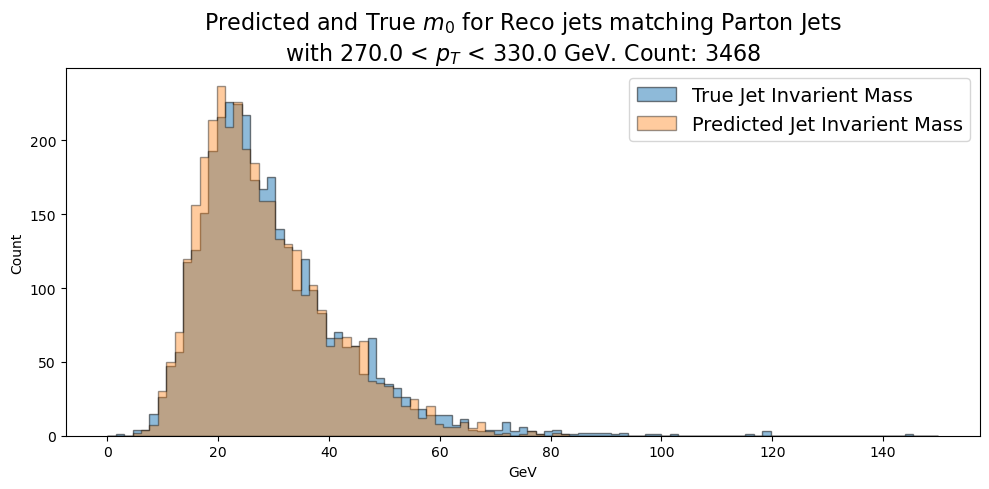

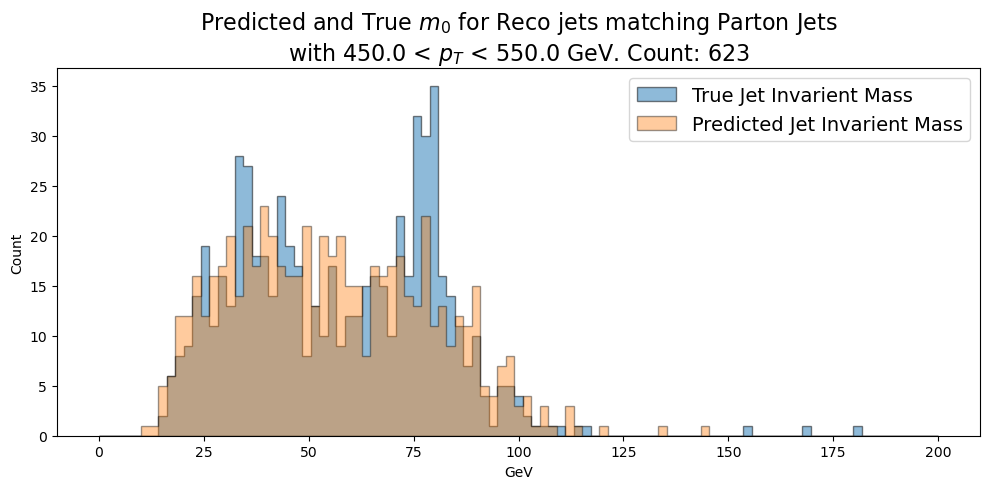

In [34]:
range_highs = [20, 50, 150, 200]#, 500, 500, 1000, 1000, 1000, 2000, 2000]
range_lows = [0, 0, 0, 0]#, 0, 0, 0, 0, 0, 0, 0]
j = 0
for center in [20, 100, 300, 500]:#, 100, 125, 150, 200, 250, 300, 600]:        
    recoM = []
    predM = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            #recoM.append(np.sqrt(data[i, 7]**2 + psquared(data[i, 4], data[i, 5])))
            recoM.append(data[i, 7])
            #predM.append(np.sqrt(predict[i, 3]**2 + psquared(predict[i, 0], predict[i, 1])))
            predM.append(predict[i, 3])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoM, bins=bins, label='True Jet Invarient Mass', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predM, bins=bins, label='Predicted Jet Invarient Mass', alpha=0.4, ec="k", histtype='stepfilled')
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap(r"Predicted and True $m_0$ for Reco jets matching Parton Jets with {} < $p_T$ < {} GeV. Count: {}".format(low, high, len(recoM)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    j+=1

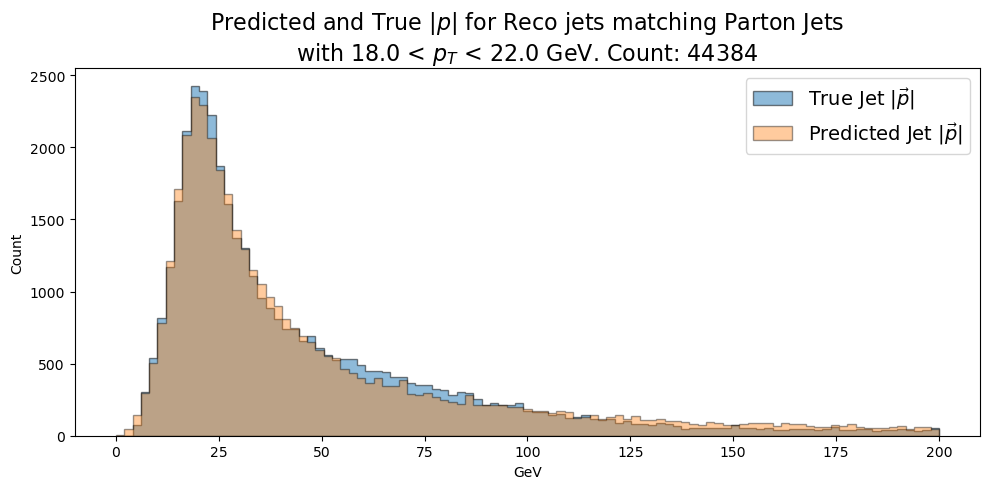

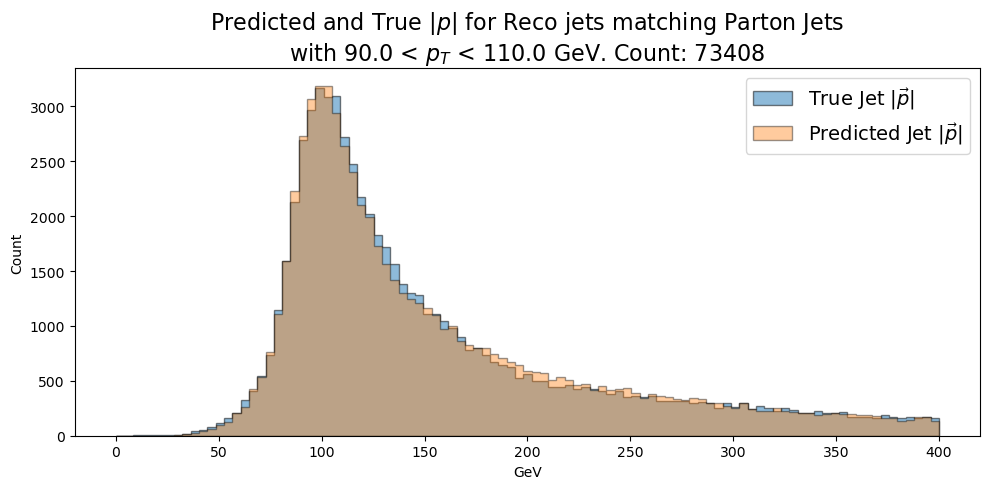

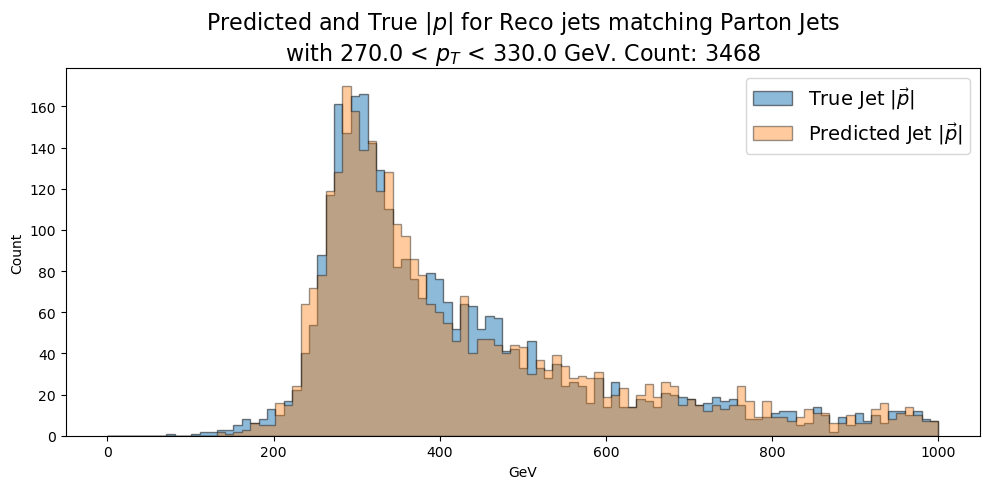

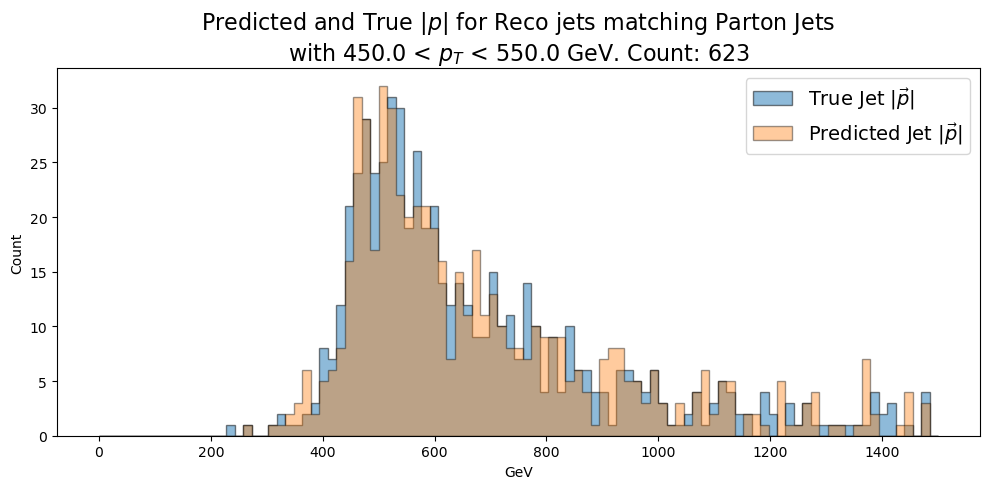

In [71]:
range_highs = [200, 400, 1000, 1500]#, 500, 500, 1000, 1000, 1000, 2000, 2000]
range_lows = [0, 0, 0, 0]#, 0, 0, 0, 0, 0, 0, 0]
j = 0
for center in [20, 100, 300, 500]:#, 100, 125, 150, 200, 250, 300, 600]:        
    recoM = []
    predM = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            #recoM.append(data[i, 7]**2 - psquared(data[i, 4], data[i, 5]))
            recoM.append(np.sqrt(psquared(data[i, 4], data[i, 5])))
            #predM.append(predict[i, 3]**2 - psquared(predict[i, 0], predict[i, 1]))
            predM.append(np.sqrt(psquared(predict[i, 0], predict[i, 1])))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoM, bins=bins, label=r'True Jet $|\vec{p}|$', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predM, bins=bins, label=r'Predicted Jet $|\vec{p}|$', alpha=0.4, ec="k", histtype='stepfilled')
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap(r"Predicted and True $|p|$ for Reco jets matching Parton Jets with {} < $p_T$ < {} GeV. Count: {}".format(low, high, len(recoM)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    j+=1

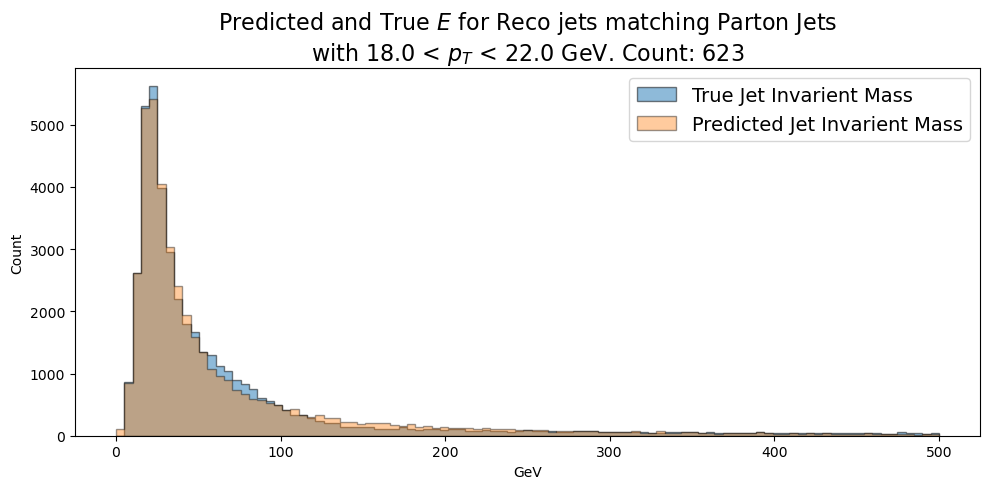

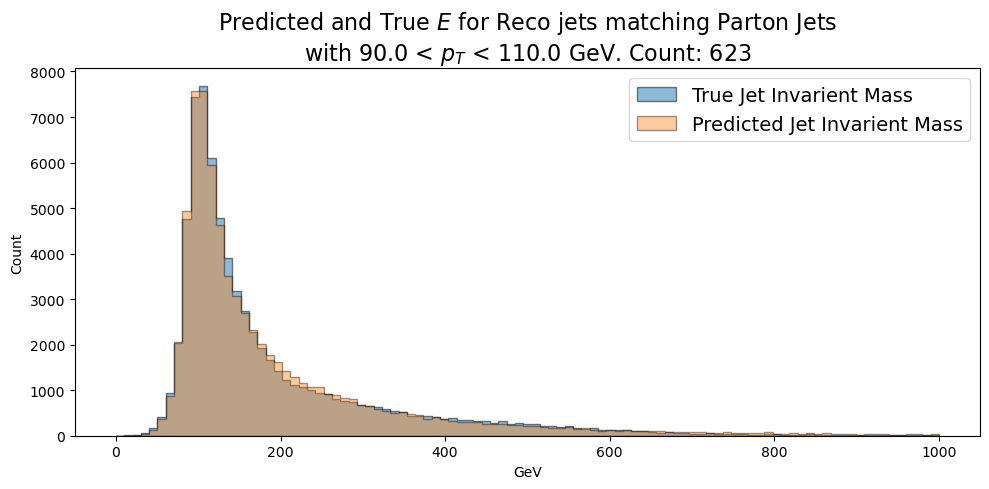

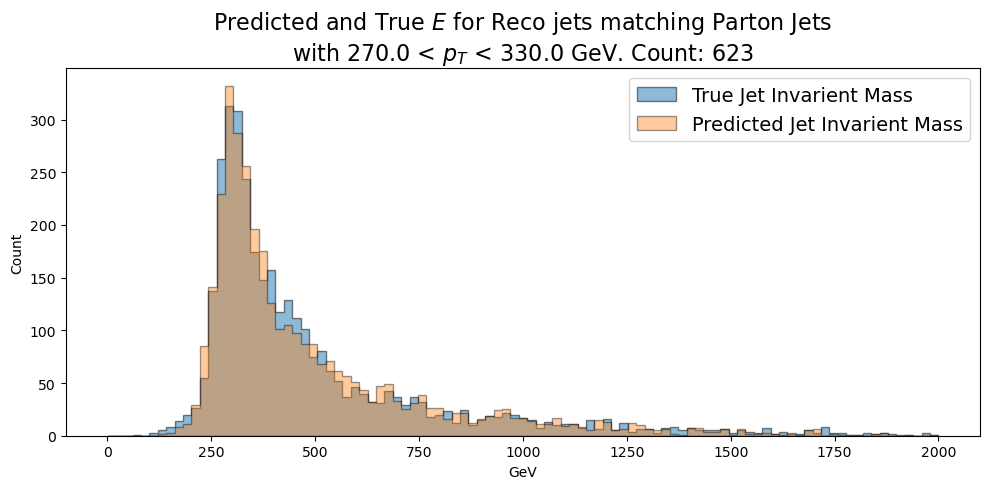

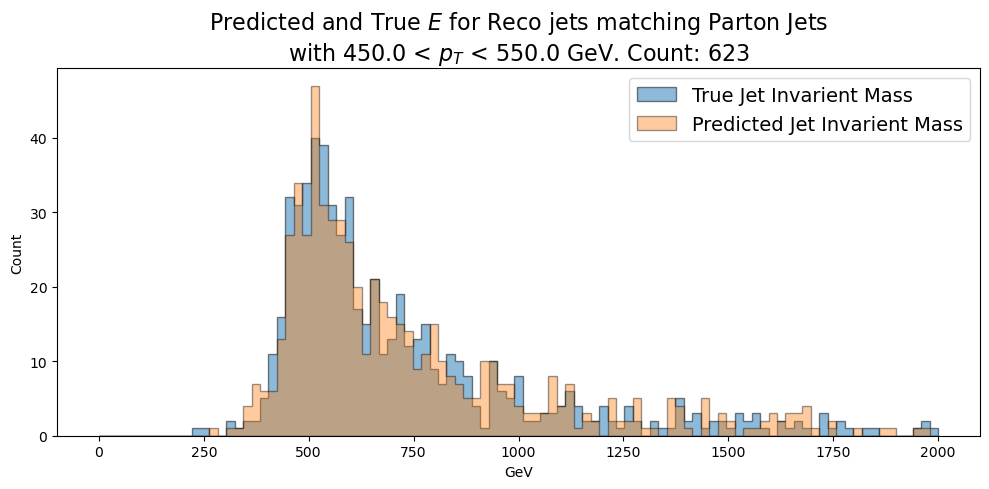

In [72]:
range_highs = [500, 1000, 2000, 2000]#, 500, 500, 1000, 1000, 1000, 2000, 2000]
range_lows = [0, 0, 0, 0]#, 0, 0, 0, 0, 0, 0, 0]
j = 0
for center in [20, 100, 300, 500]:#, 100, 125, 150, 200, 250, 300, 600]:        
    recoE = []
    predE = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoE.append(np.sqrt(data[i, 7]**2 + psquared(data[i, 4], data[i, 5])))
            #recoM.append(psquared(data[i, 4], data[i, 5]))
            predE.append(np.sqrt(predict[i, 3]**2 + psquared(predict[i, 0], predict[i, 1])))
            #predM.append(psquared(predict[i, 0], predict[i, 1]))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoE, bins=bins, label='True Jet Invarient Mass', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predE, bins=bins, label='Predicted Jet Invarient Mass', alpha=0.4, ec="k", histtype='stepfilled')
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap(r"Predicted and True $E$ for Reco jets matching Parton Jets with {} < $p_T$ < {} GeV. Count: {}".format(low, high, len(recoM)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    j+=1

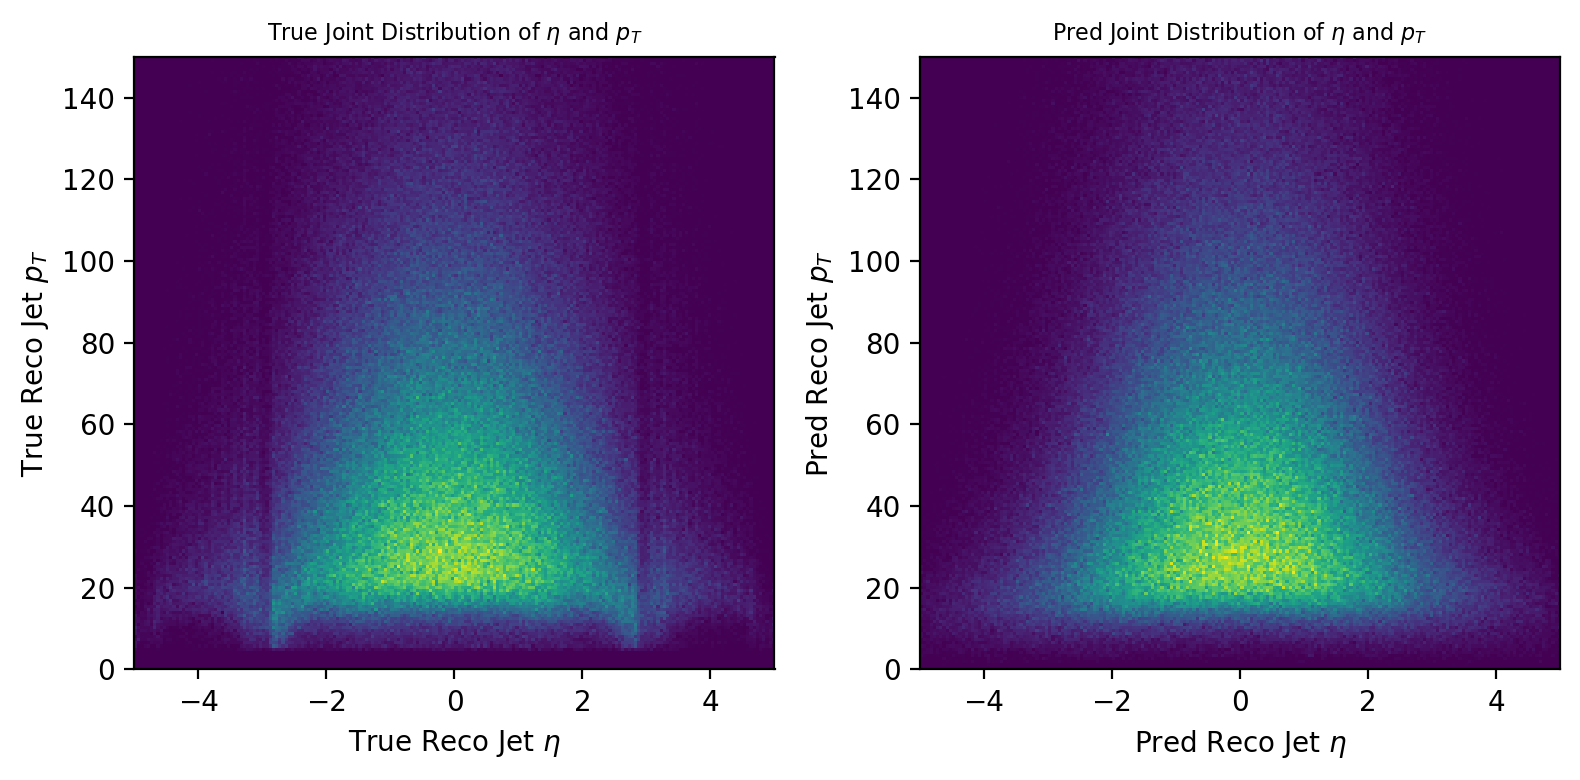

In [78]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 150
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$")
ax1.set_ylabel(r"True Reco Jet $p_T$")
ax1.set_title("True Joint Distribution of $\eta$ and $p_T$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 1], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\eta$")
ax2.set_ylabel(r"Pred Reco Jet $p_T$")
ax2.set_title("Pred Joint Distribution of $\eta$ and $p_T$", size=8)

plt.tight_layout()
plt.show()

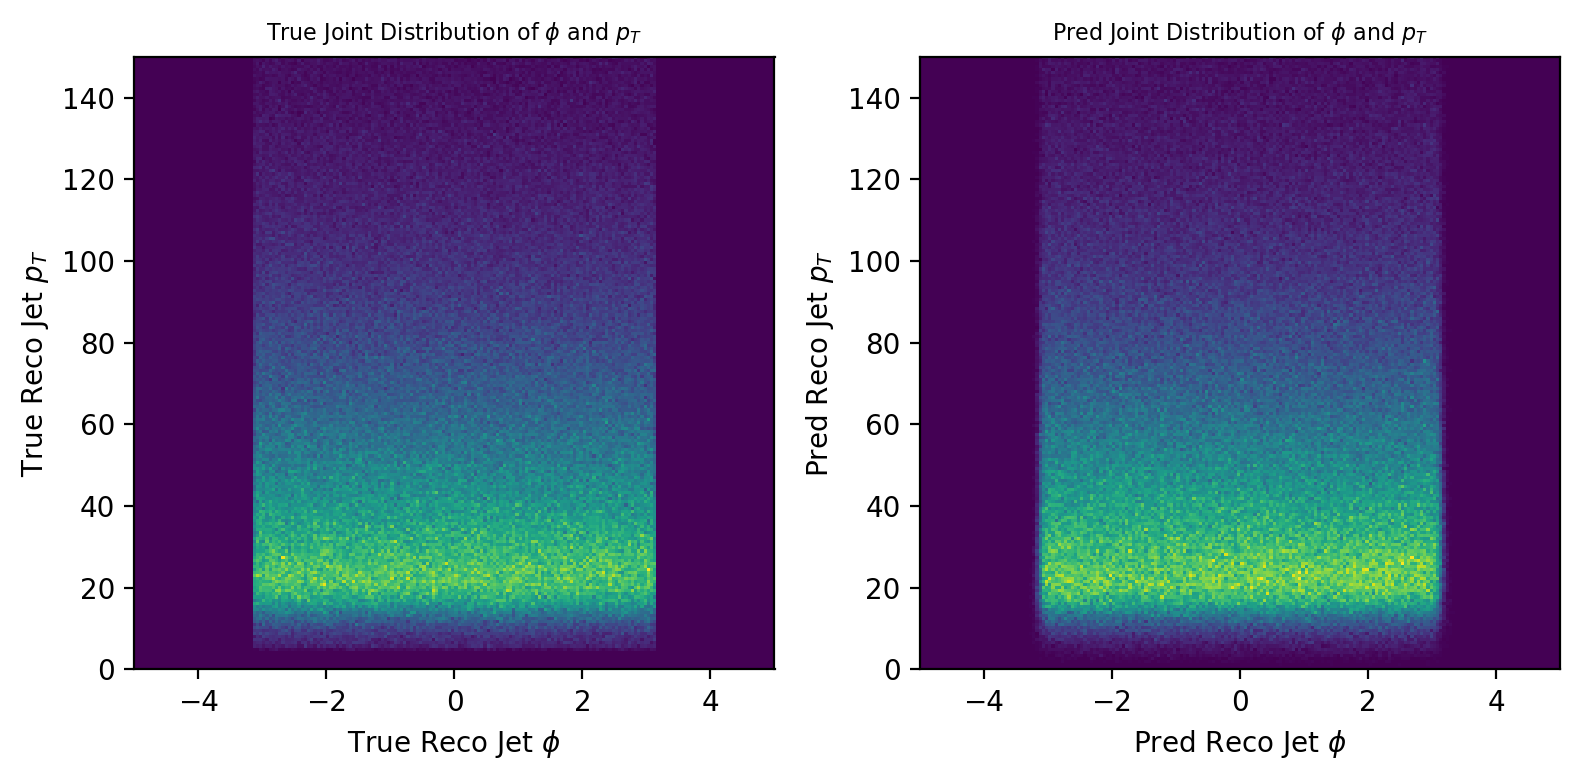

In [79]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 150
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 6], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\phi$")
ax1.set_ylabel(r"True Reco Jet $p_T$")
ax1.set_title("True Joint Distribution of $\phi$ and $p_T$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 2], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\phi$")
ax2.set_ylabel(r"Pred Reco Jet $p_T$")
ax2.set_title("Pred Joint Distribution of $\phi$ and $p_T$", size=8)

plt.tight_layout()
plt.show()

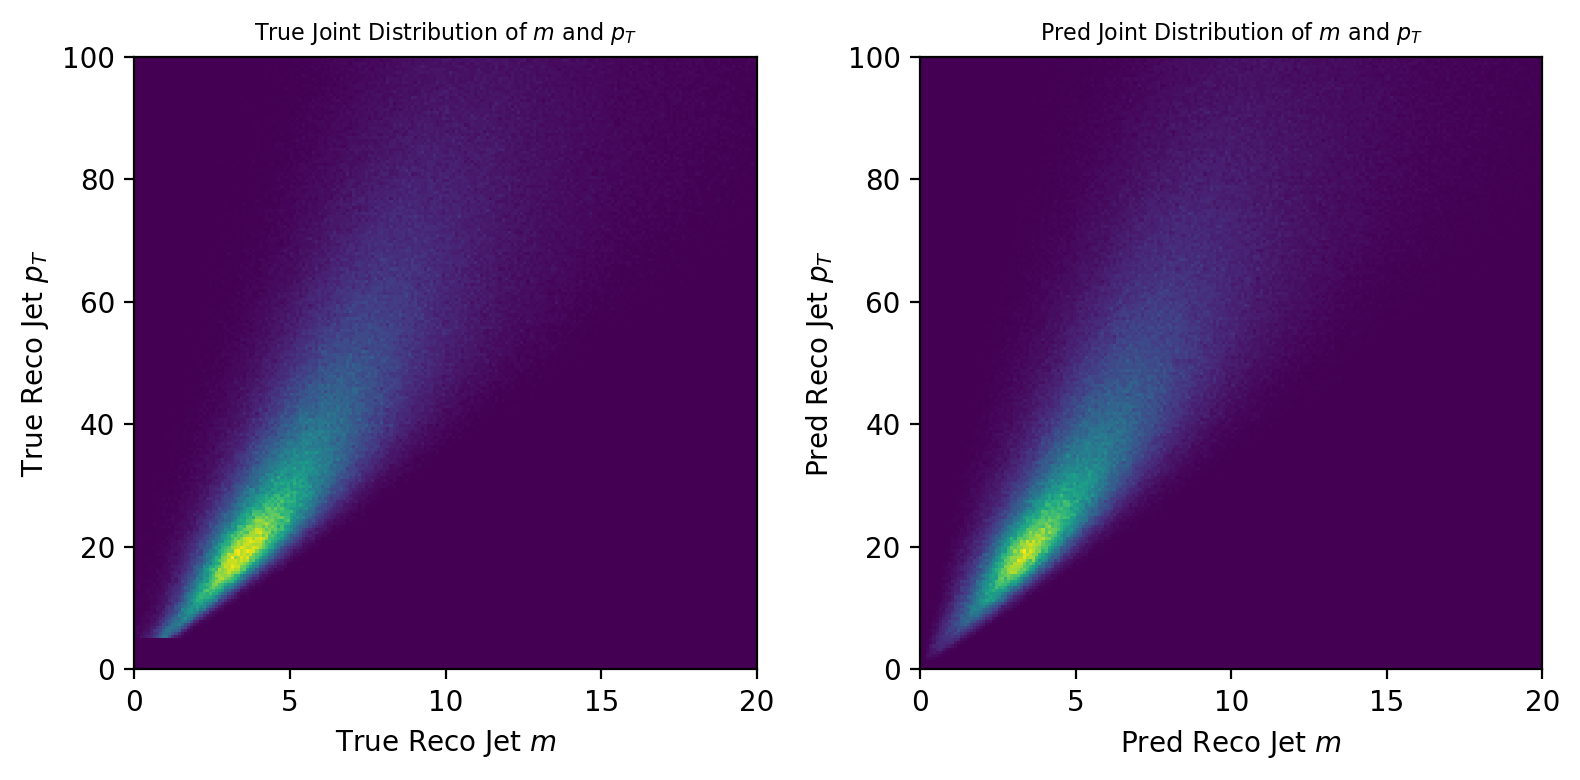

In [83]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 0
x_hi = 20
y_low = 0
y_hi = 100
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 7], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $m$")
ax1.set_ylabel(r"True Reco Jet $p_T$")
ax1.set_title("True Joint Distribution of $m$ and $p_T$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 3], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $m$")
ax2.set_ylabel(r"Pred Reco Jet $p_T$")
ax2.set_title("Pred Joint Distribution of $m$ and $p_T$", size=8)

plt.tight_layout()
plt.show()

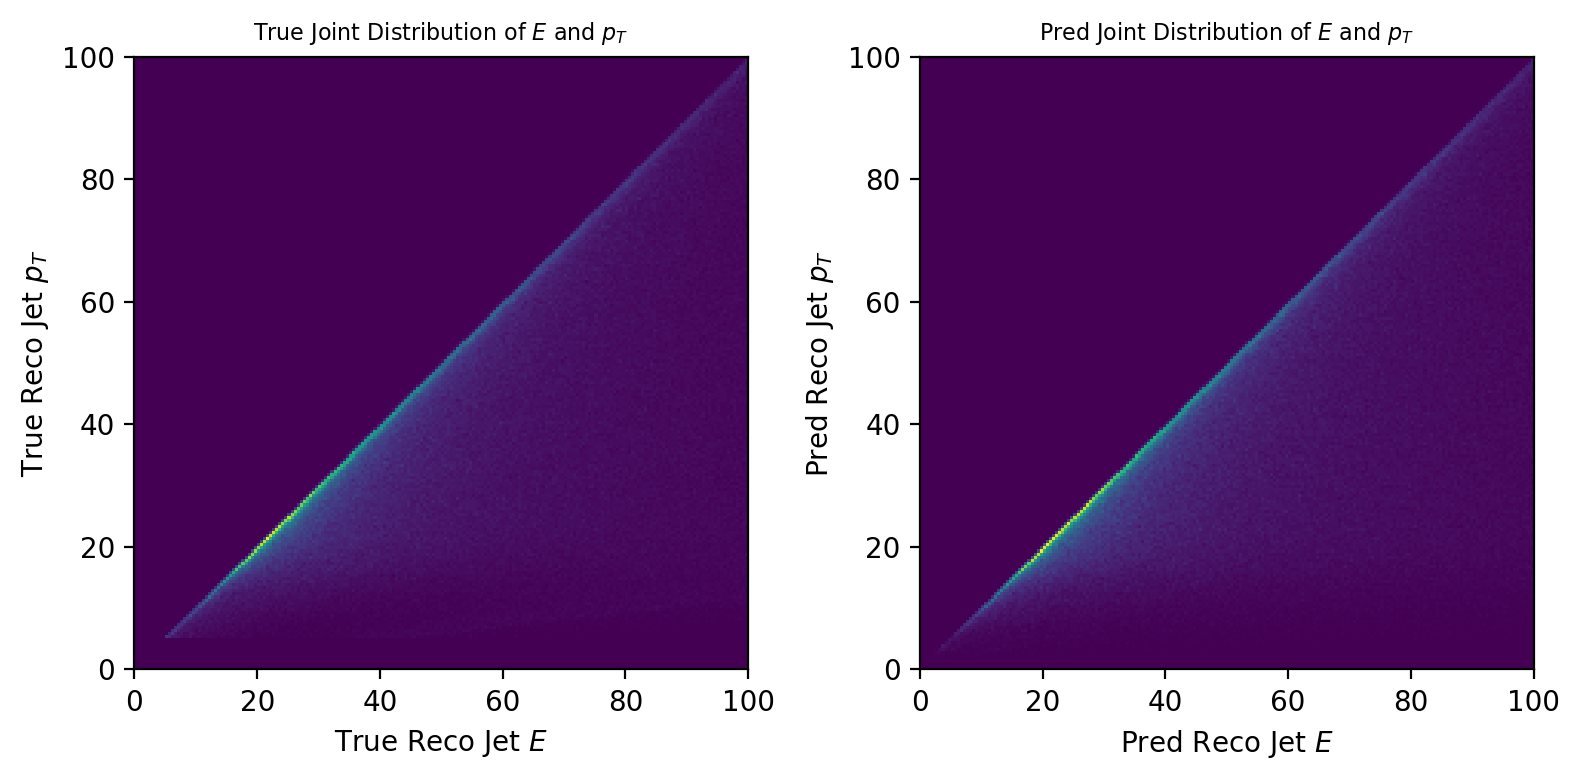

In [86]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 0
x_hi = 100
y_low = 0
y_hi = 100
num_bins=200

h2, xbins, ybins = np.histogram2d(np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $E$")
ax1.set_ylabel(r"True Reco Jet $p_T$")
ax1.set_title("True Joint Distribution of $E$ and $p_T$", size=8)

z2, xbins, ybins = np.histogram2d(np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $E$")
ax2.set_ylabel(r"Pred Reco Jet $p_T$")
ax2.set_title("Pred Joint Distribution of $E$ and $p_T$", size=8)

plt.tight_layout()
plt.show()

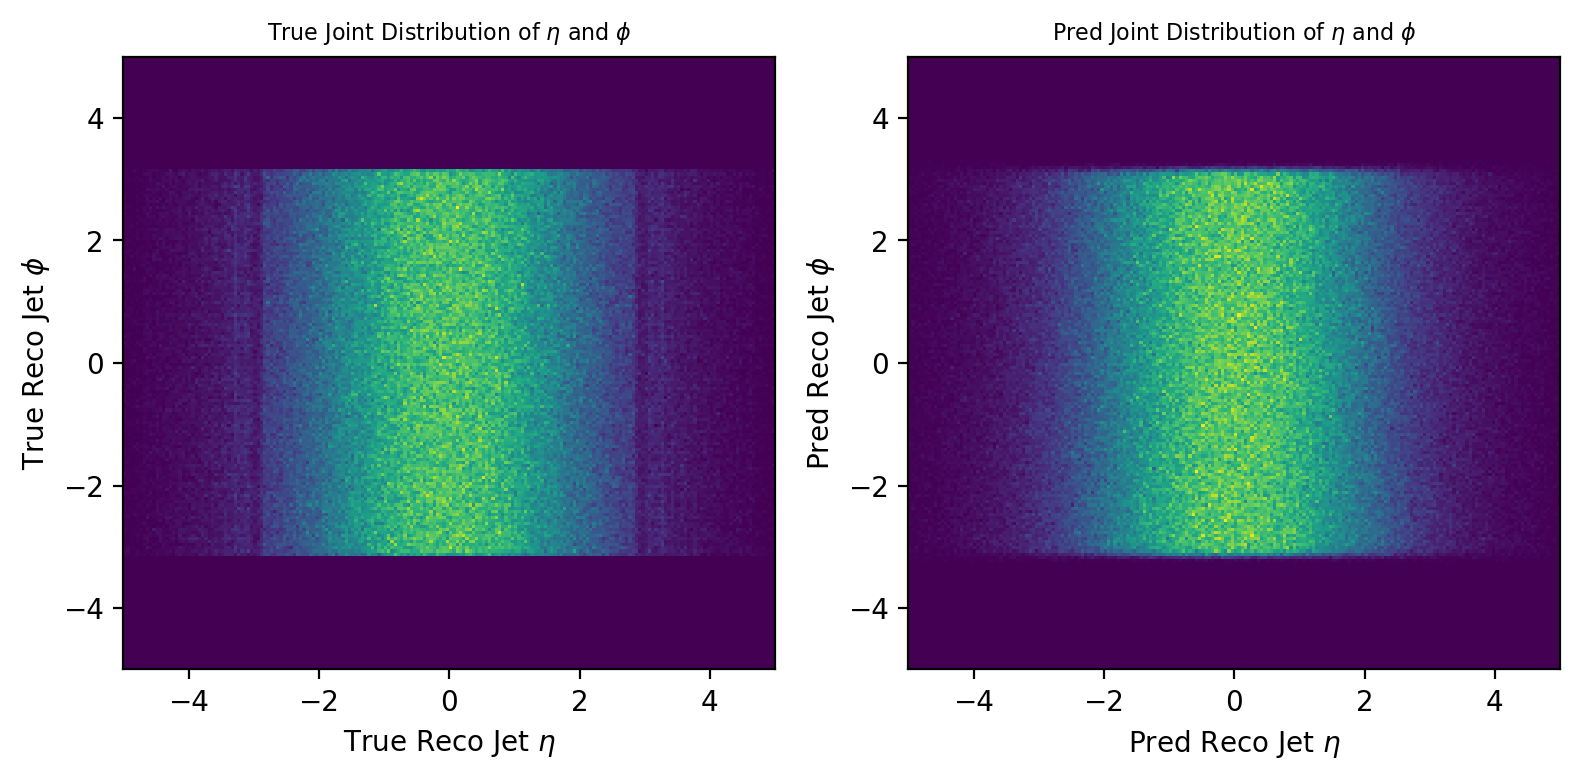

In [89]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = -5
y_hi = 5
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], data[:, 6], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$")
ax1.set_ylabel(r"True Reco Jet $\phi$")
ax1.set_title("True Joint Distribution of $\eta$ and $\phi$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 1], predict[:, 2], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\eta$")
ax2.set_ylabel(r"Pred Reco Jet $\phi$")
ax2.set_title("Pred Joint Distribution of $\eta$ and $\phi$", size=8)

plt.tight_layout()
plt.show()

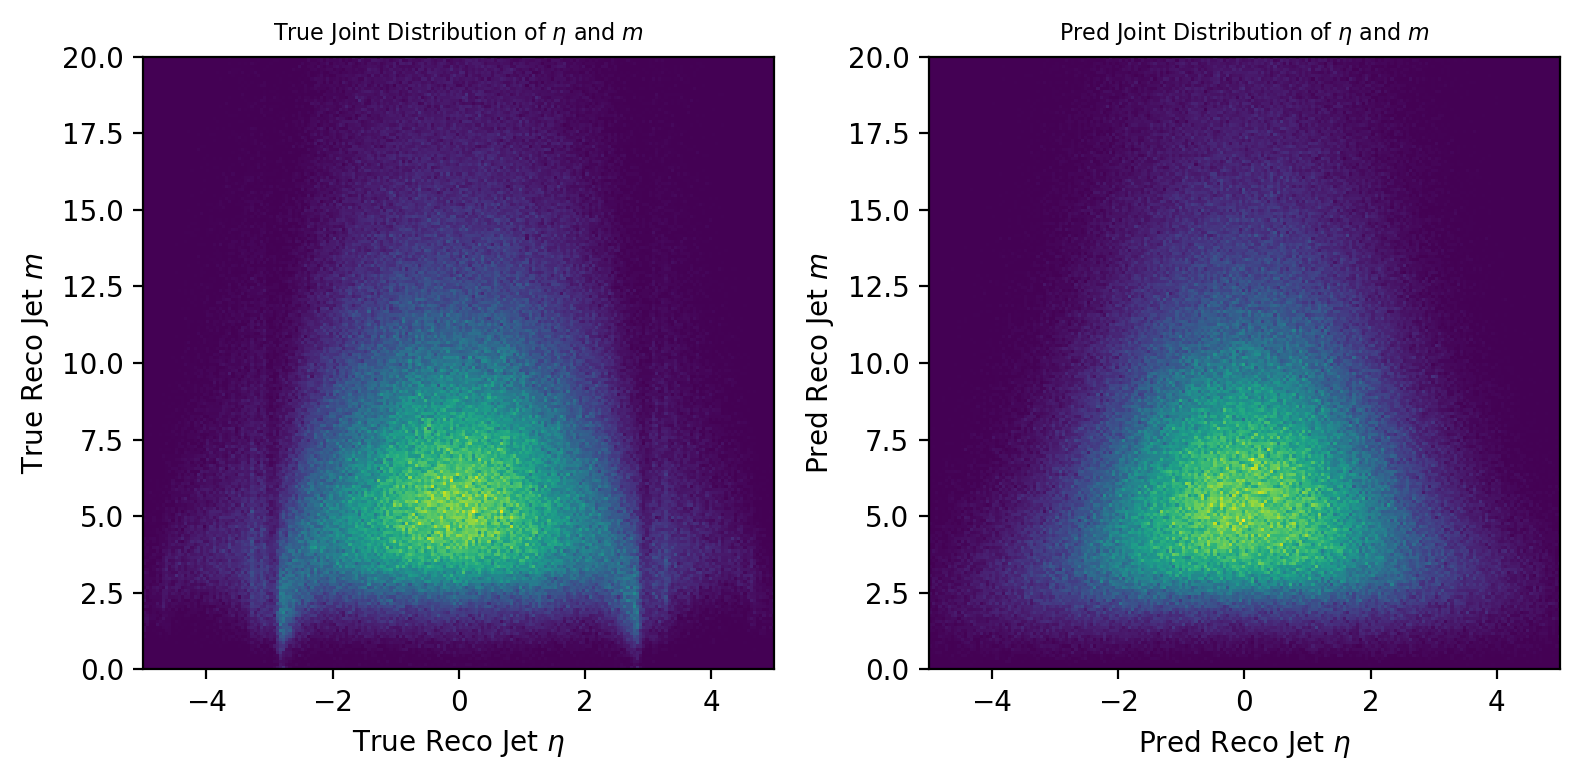

In [90]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 20
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], data[:, 7], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$")
ax1.set_ylabel(r"True Reco Jet $m$")
ax1.set_title("True Joint Distribution of $\eta$ and $m$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 1], predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\eta$")
ax2.set_ylabel(r"Pred Reco Jet $m$")
ax2.set_title("Pred Joint Distribution of $\eta$ and $m$", size=8)

plt.tight_layout()
plt.show()

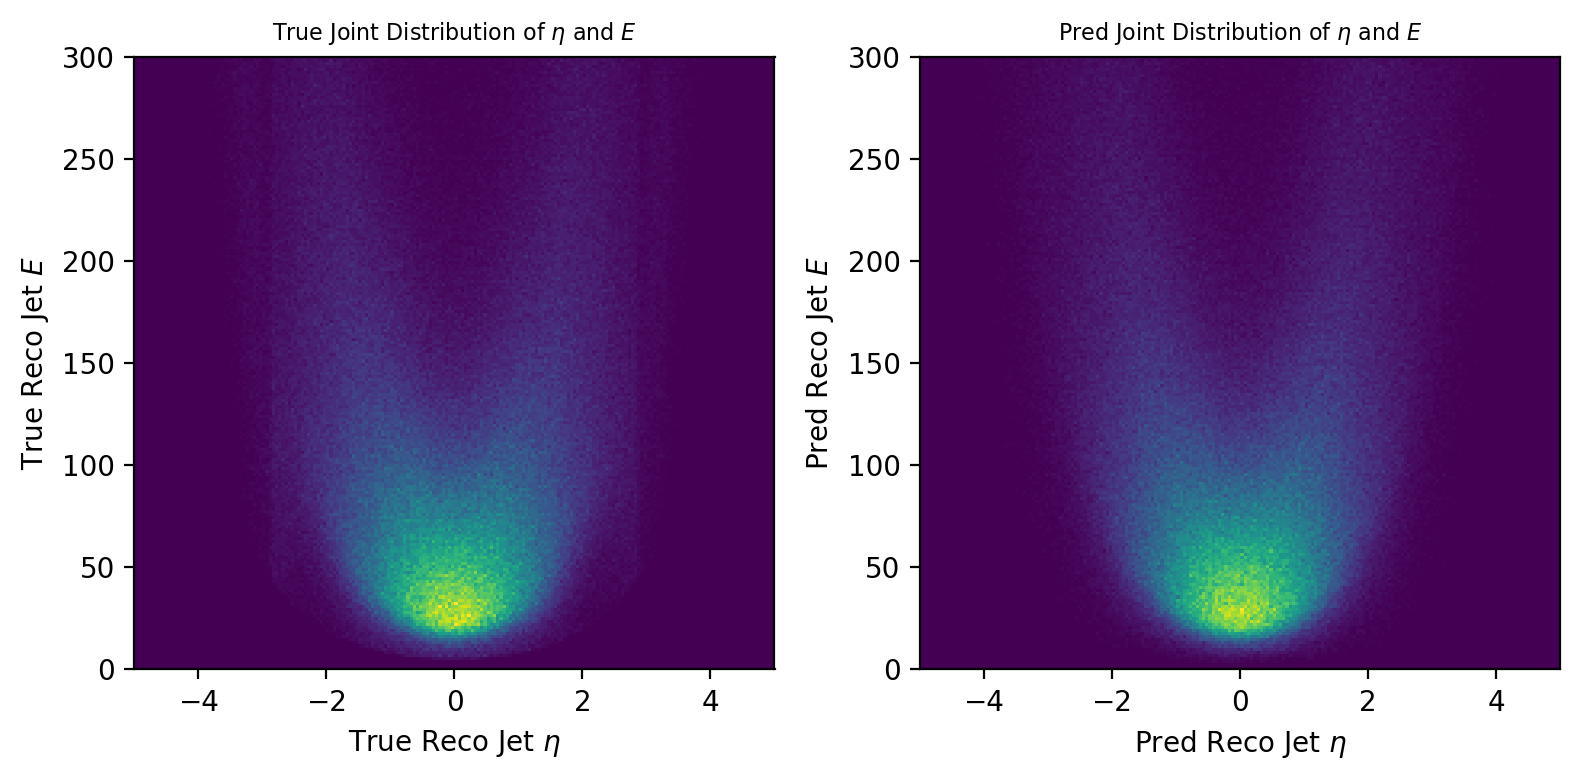

In [93]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 300
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 5], np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\eta$")
ax1.set_ylabel(r"True Reco Jet $E$")
ax1.set_title("True Joint Distribution of $\eta$ and $E$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 1], np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\eta$")
ax2.set_ylabel(r"Pred Reco Jet $E$")
ax2.set_title("Pred Joint Distribution of $\eta$ and $E$", size=8)

plt.tight_layout()
plt.show()

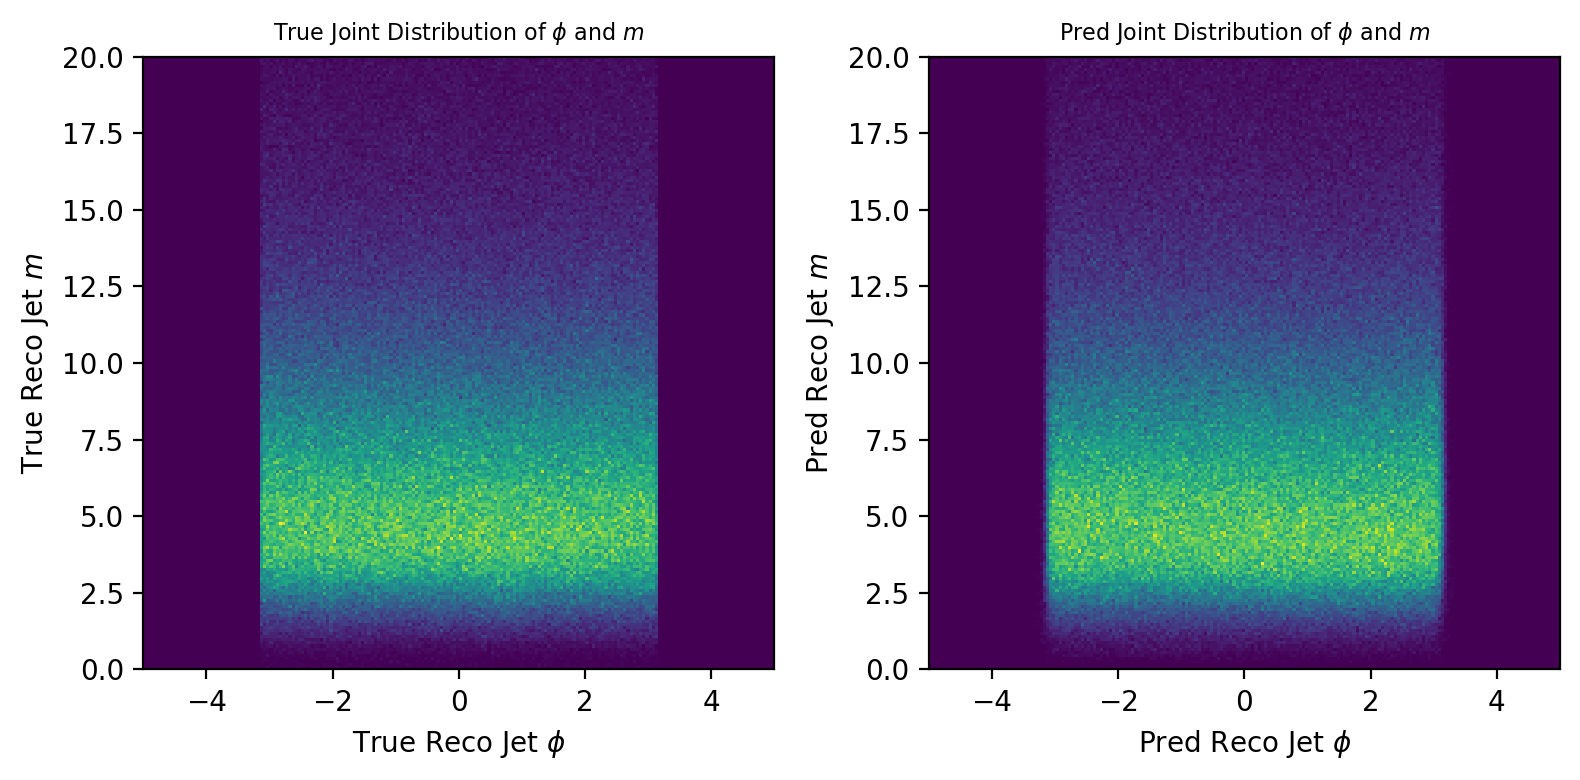

In [94]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 20
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 6], data[:, 7], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\phi$")
ax1.set_ylabel(r"True Reco Jet $m$")
ax1.set_title("True Joint Distribution of $\phi$ and $m$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 2], predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\phi$")
ax2.set_ylabel(r"Pred Reco Jet $m$")
ax2.set_title("Pred Joint Distribution of $\phi$ and $m$", size=8)

plt.tight_layout()
plt.show()

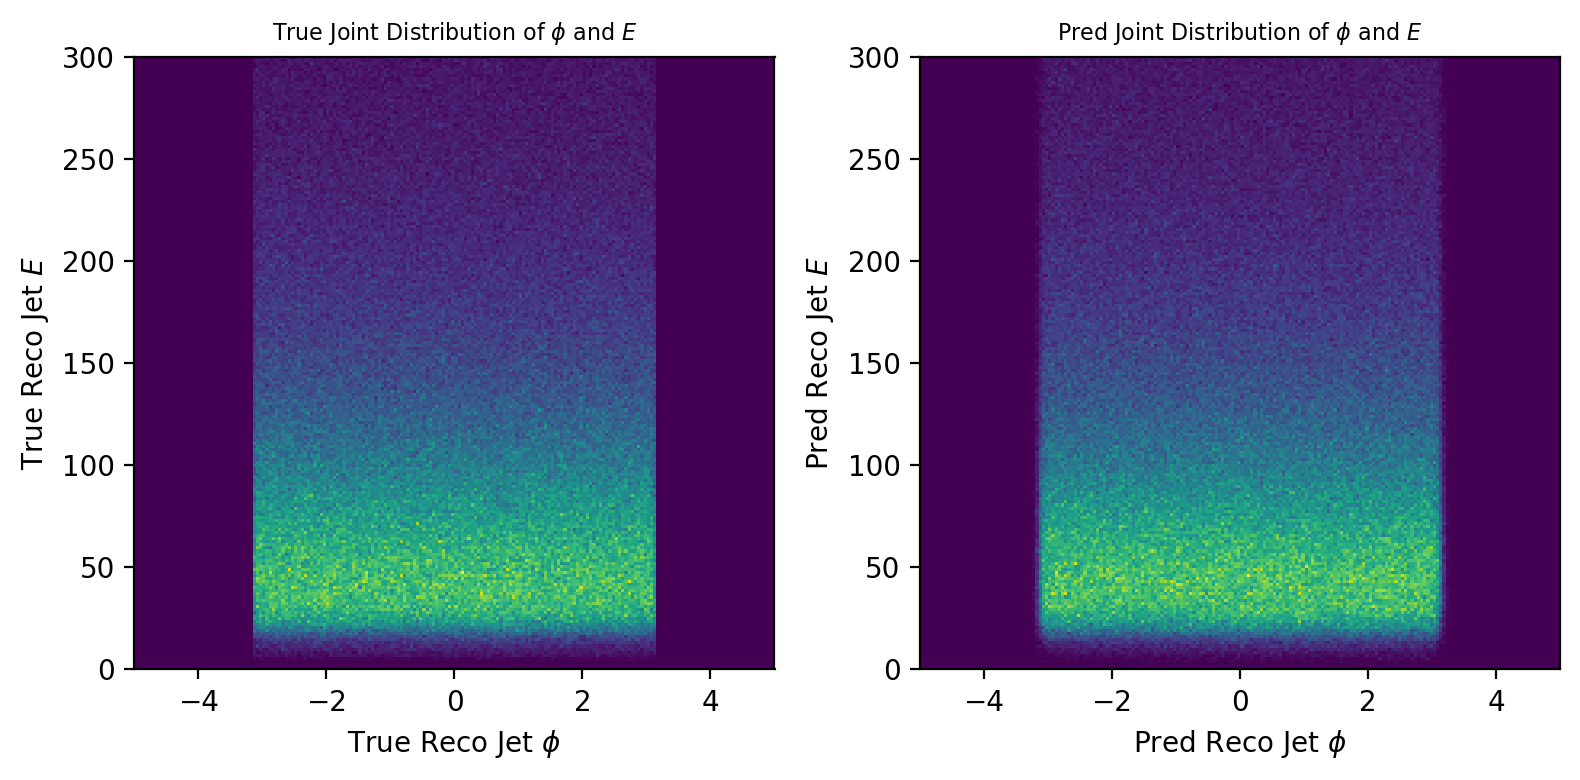

In [95]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = -5
x_hi = 5
y_low = 0
y_hi = 300
num_bins=200

h2, xbins, ybins = np.histogram2d(data[:, 6], np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $\phi$")
ax1.set_ylabel(r"True Reco Jet $E$")
ax1.set_title("True Joint Distribution of $\phi$ and $E$", size=8)

z2, xbins, ybins = np.histogram2d(predict[:, 2], np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $\phi$")
ax2.set_ylabel(r"Pred Reco Jet $E$")
ax2.set_title("Pred Joint Distribution of $\phi$ and $E$", size=8)

plt.tight_layout()
plt.show()

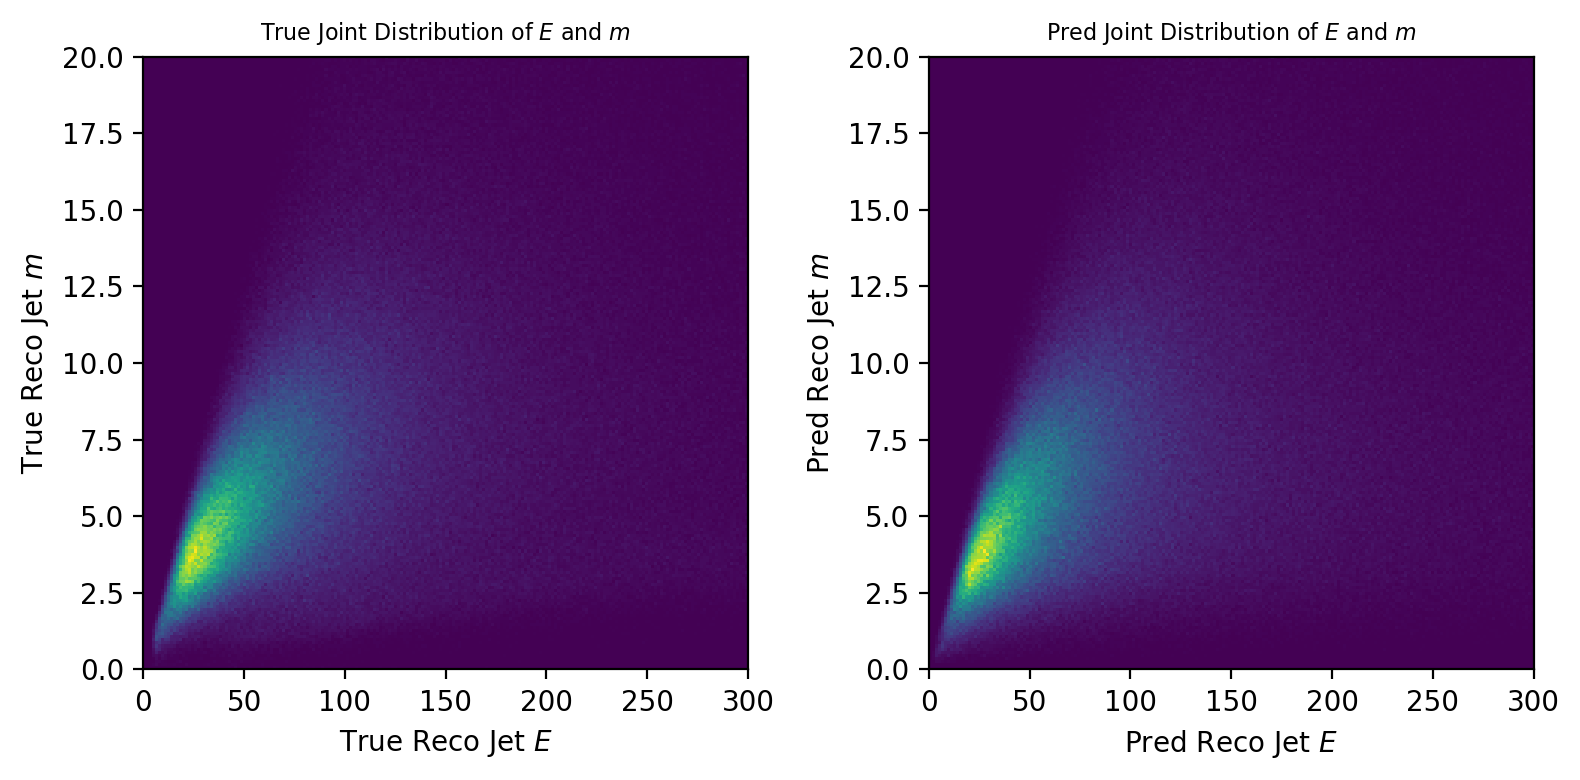

In [96]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 0
x_hi = 300
y_low = 0
y_hi = 20
num_bins=200

h2, xbins, ybins = np.histogram2d(np.sqrt(data[:, 7]**2 + (data[:, 4]*np.cosh(data[:, 5]))**2), data[:, 7], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"True Reco Jet $E$")
ax1.set_ylabel(r"True Reco Jet $m$")
ax1.set_title("True Joint Distribution of $E$ and $m$", size=8)

z2, xbins, ybins = np.histogram2d(np.sqrt(predict[:, 3]**2 + (predict[:, 0]*np.cosh(predict[:, 1]))**2), predict[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi))#, cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Pred Reco Jet $E$")
ax2.set_ylabel(r"Pred Reco Jet $m$")
ax2.set_title("Pred Joint Distribution of $E$ and $m$", size=8)

plt.tight_layout()
plt.show()

In [16]:
delphes_data = np.loadtxt("../test_test.txt", skiprows=2)

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 400
y_low = -30
y_hi = 400
num_bins=200


h2, xbins, ybins = np.histogram2d(data[:, 0], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel("Parton Jet Pt")
ax1.set_ylabel("True Reco Jet Pt")
ax1.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=10)
#ax1.set_xlim(0, 200)
#ax1.set_ylim(0, 200)


z2, xbins, ybins = np.histogram2d(delphes_data[:, 0], delphes_data[:, 3], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel("Parton Jet Pt")
ax2.set_ylabel("Delphes Reco Jet Pt")
ax2.set_title("Joint Distribution of Parton Jet Pt and Delphes Reco Jet Pt ", size=8)
#ax2.set_xlim(0, 200)
#ax2.set_ylim(-50, 200)

# plot y=x line to make comparison easier
x = np.linspace(x_low, x_hi, 10)
ax1.plot(x, x, c='r', alpha=0.5)
ax2.plot(x, x, c='r', alpha=0.5)

plt.tight_layout()
plt.show()
#plt.savefig(save_dir + '/JointPtDistributions.png')

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 100
y_low = -30
y_hi = 100
num_bins=100


h2, xbins, ybins = np.histogram2d(data[:, 0], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys")#, norm=mcolors.LogNorm())
ax1.set_xlabel("Parton Jet Pt")
ax1.set_ylabel("True Reco Jet Pt")
ax1.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=10)
#ax1.set_xlim(0, 200)
#ax1.set_ylim(0, 200)


z2, xbins, ybins = np.histogram2d(delphes_data[:, 0], delphes_data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys")#, norm=mcolors.LogNorm())
ax2.set_xlabel("Parton Jet Pt")
ax2.set_ylabel("Delphes Reco Jet Pt")
ax2.set_title("Joint Distribution of Parton Jet Pt and Delphes Reco Jet Pt ", size=8)
#ax2.set_xlim(0, 200)
#ax2.set_ylim(-50, 200)

# plot y=x line to make comparison easier
x = np.linspace(x_low, x_hi, 10)
ax1.plot(x, x, c='r', alpha=0.5)
ax2.plot(x, x, c='r', alpha=0.5)

plt.tight_layout()
plt.show()
#plt.savefig(save_dir + '/JointPtDistributions.png')

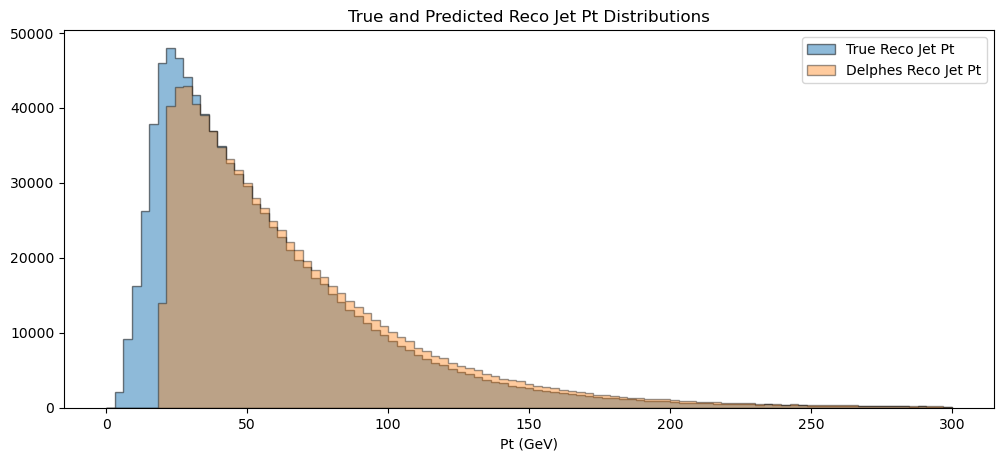

In [17]:
fig = plt.figure(figsize=(12,5), dpi=100)
bins = np.linspace(0, 300, 100)
ax = fig.add_subplot(111)
ax.hist(data[:, 4], label="True Reco Jet Pt", bins=bins, alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(delphes_data[:, 3], label="Delphes Reco Jet Pt", bins=bins, alpha=0.4, ec="k", histtype='stepfilled')
ax.set_title("True and Predicted Reco Jet Pt Distributions")
ax.set_xlabel("Pt (GeV)")
ax.legend()
plt.show()

center=50
102810
103651


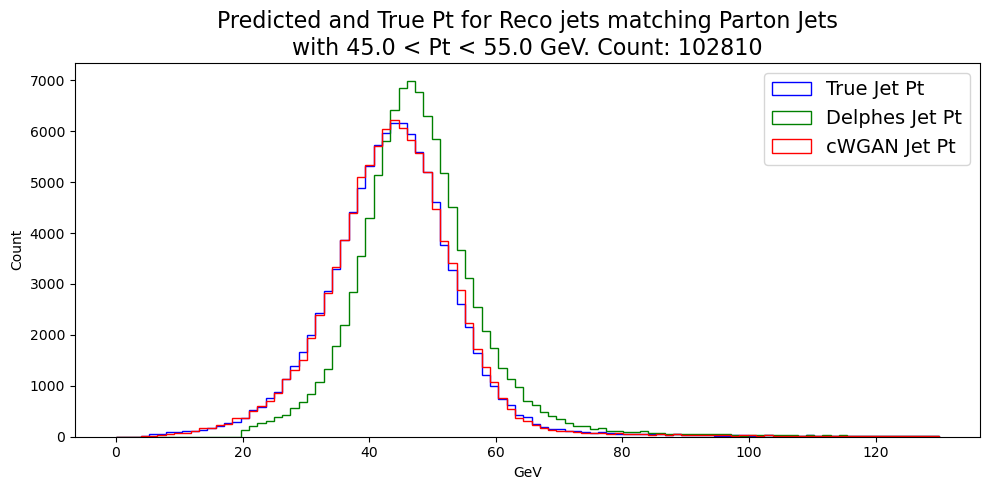

center=75
94372
94461


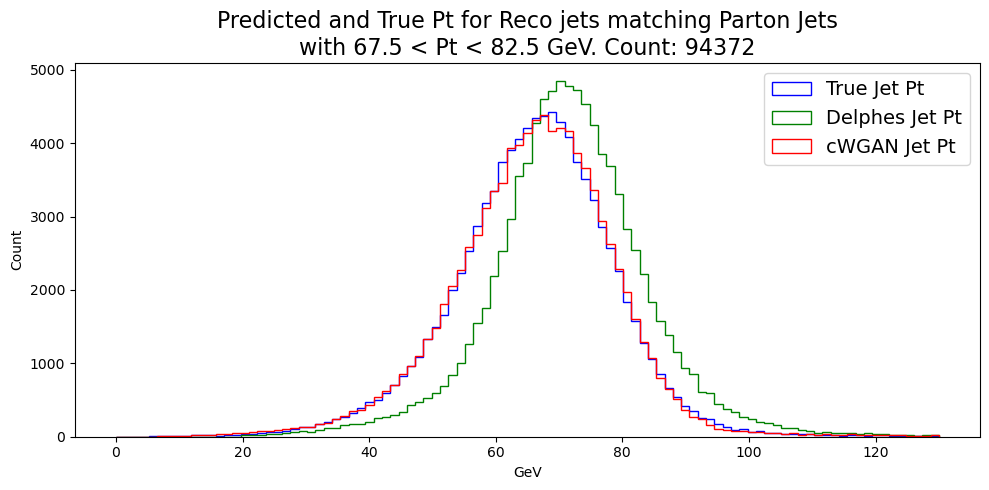

center=100
73403
73418


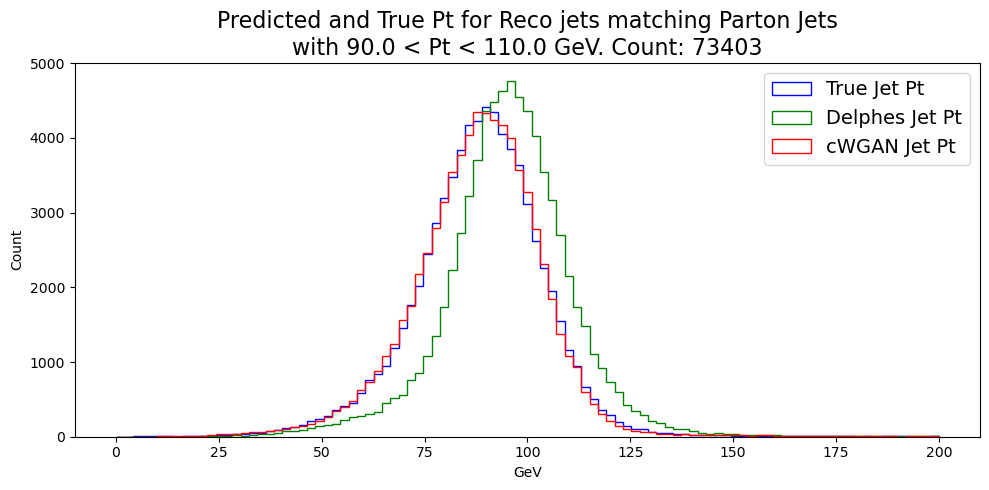

center=125
50713
50724


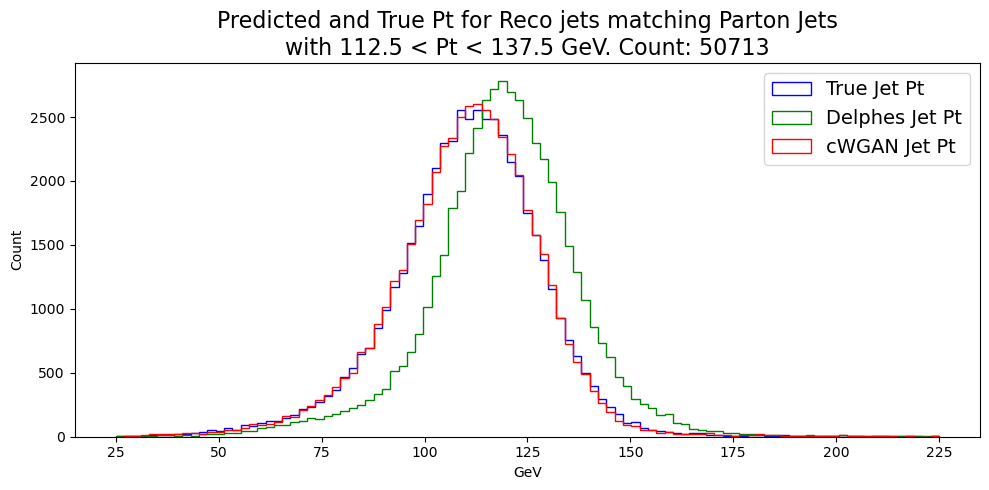

center=150
33514
33519


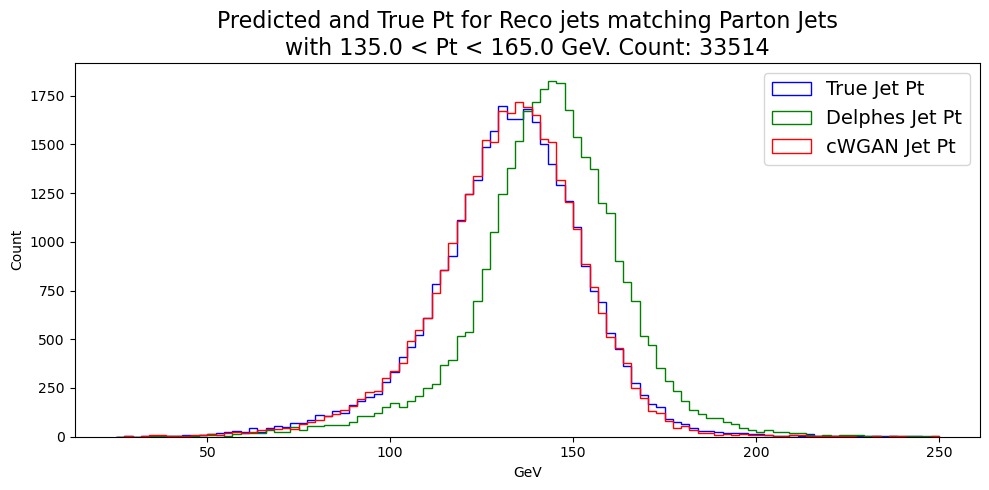

center=200
14431
14435


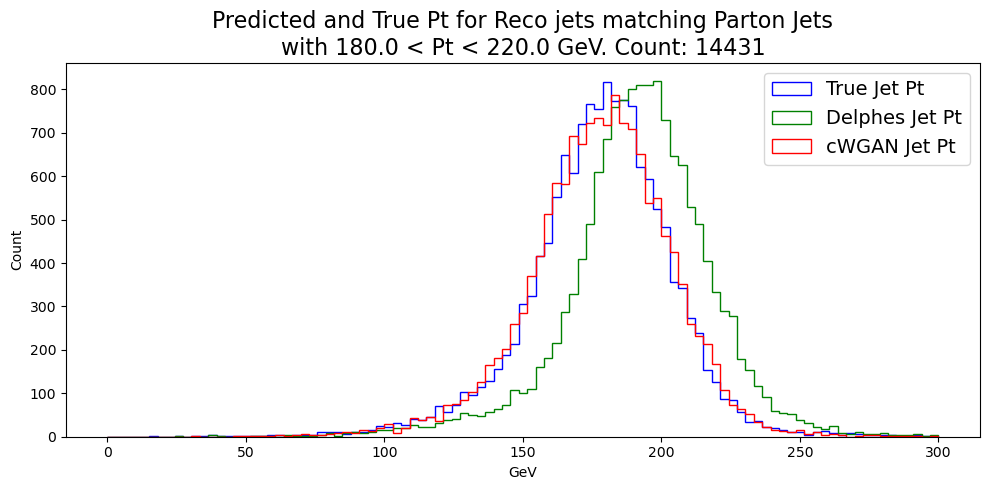

center=250
6721
6721


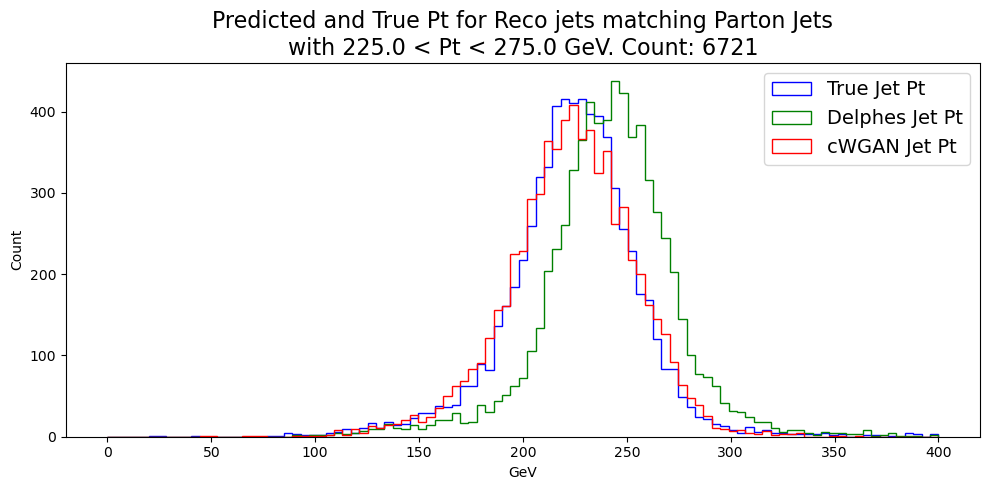

center=300
3469
3469


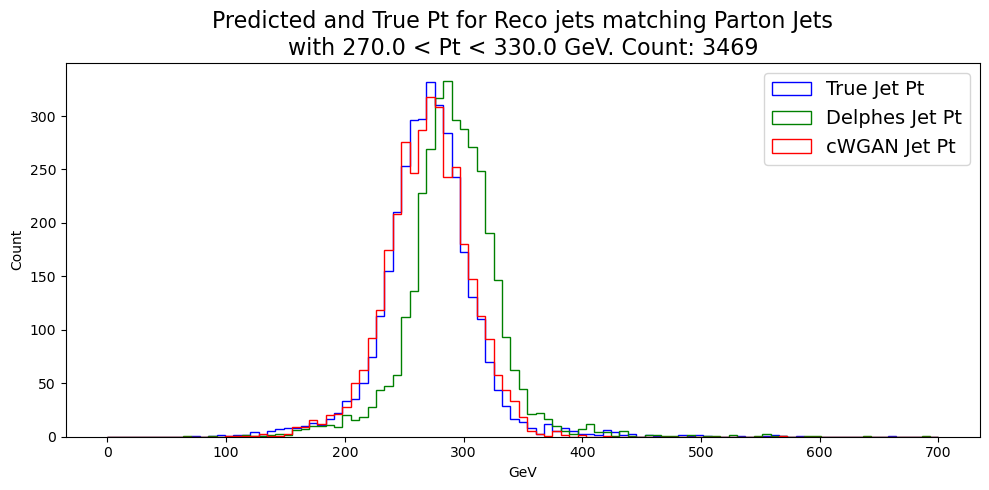

center=600
329
329


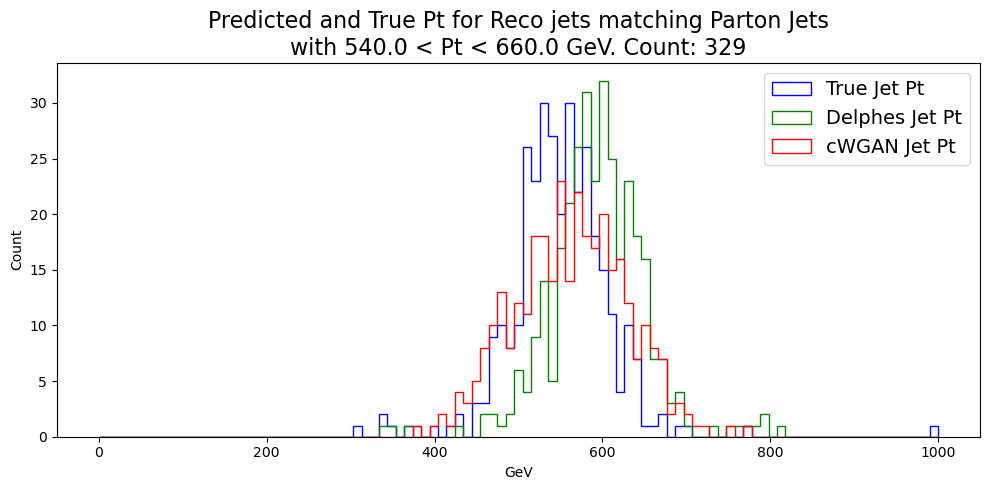

In [18]:
range_highs = [130, 130, 200, 225, 250, 300, 400, 700, 1000]
range_lows = [0, 0, 0, 25, 25, 0, 0, 0, 0]
j = 0
for center in [50, 75, 100, 125, 150, 200, 250, 300, 600]:  
    print("center={}".format(center))
    delphesPartons = []
    realPartons = []
    delphesPt = []
    delphesGen = []
    realGen = []
    realPt = []
    predPt = []
    pfCandPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(delphes_data)):
        if (delphes_data[i, 0] > low and delphes_data[i, 0] < high):
            #delphesPartons.append(delphes_data[i, 0])
            delphesPt.append(delphes_data[i, 3])
            pfCandPt.append(delphes_data[i, 12])
            #print(delphes_data[i, 12])
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            realPt.append(data[i, 4])
            predPt.append(predict[i, 0])
            #realPartons.append(data[i, 0])
    print(len(pfCandPt))
    print(len(realPt))
    #assert(len(pfCandPt) == len(realPt))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(realPt, bins=bins, label='True Jet Pt', alpha=1, ec="b", histtype='step')
    #ax.hist(pfCandPt, bins=bins, label='Pf Cand Jet Pt', alpha=1, ec="r", histtype='step')
    ax.hist(delphesPt, bins=bins, label='Delphes Jet Pt', alpha=1, ec="g", histtype='step')
    #ax.hist(delphesPartons, bins=bins, label='Delphes Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    #ax.hist(realPartons, bins=bins, label='Delphes Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predPt, bins=bins, label='cWGAN Jet Pt', alpha=1, ec="r", histtype='step')

    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(delphesPt)), width=60)), fontsize=16)
    #ax.axvline(center)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig(save_dir+"/PtDistLog{}.png".format(j), facecolor="white", transparent="True")
    j+=1



In [ ]:
range_highs = [100, 130, 130, 200, 225, 250, 300, 400, 700, 1000]
range_lows = [0, 0, 0, 0, 25, 25, 0, 0, 0, 0]
j = 0
delphesGenPt = []
for center in [20, 50, 75, 100, 125, 150, 200, 250, 300, 600]:     
    delphesPartons = []
    realPartons = []
    recoPt = []
    delphesRecoPt = []
    delphesGenPt = []
    realGenPt = []
    low = center - center/50
    high = center + center/50
    for i in range(len(delphes_data)):
        if (delphes_data[i, 0] > low and delphes_data[i, 0] < high):
            delphesPartons.append(delphes_data[i, 0])
            delphesRecoPt.append(delphes_data[i, 3])
            delphesGenPt.append(delphes_data[i, 9])
            realGenPt.append(delphes_data[i, 6])
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            #predPt.append(predict[i, 0])
            realPartons.append(data[i, 0])
    #print(np.mean(delphesGenPt))
    print(np.mean(realGenPt))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    #ax.hist(delphesPartons, bins=bins, label='Delphes Parton Jet Pt', alpha=1, ec="b", histtype='step')
    #ax.hist(delphesRecoPt, bins=bins, label='Delphes Jet Pt', alpha=1, ec="g", histtype='step')
    #ax.hist(realPartons, bins=bins, label='Real Parton Jet Pt', alpha=0.5, ec="k", histtype='step')
    ax.hist(realGenPt, bins=bins, label='CMSSW Gen Jet Pt', alpha=1, ec="r", histtype='step')
    ax.hist(delphesGenPt, bins=bins, label='Delphes Gen Jet Pt', alpha=1, ec='y', histtype='step')
    #ax.hist(recoPt, bins=bins, label='Reco Jet Pt', alpha=1, ec="b", histtype='step')



    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("Pt of Delphes GenJets and CMSSW GenJets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(delphesRecoPt)), width=60)), fontsize=16)
    #ax.axvline(center)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig(save_dir+"/PtDistLog{}.png".format(j), facecolor="white", transparent="True")
    j+=1




In [7]:
cwgan.generator.summary()
cwgan.critic.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pjetIn (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
noiseIn (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 14)           0           pjetIn[0][0]                     
                                                                 noiseIn[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          7680        concat[0][0]                 